# Imports

In [193]:
import gzip
import json
import pandas as pd
import os
import gdelt
from gdeltdoc import GdeltDoc, Filters, near, repeat
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from tqdm.auto import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import networkx as nx
import random 
import math
from sklearn.metrics import RocCurveDisplay
import country_converter as cc
from time import sleep
import geopandas as gpd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import random

# Cyber Attacks Dataset

## Data Frame Preprocess

In [2]:
cyber_pkl_path = 'cyber_attacks_dataset/cyber_attacks.pkl'
cyber_attacks_df = pd.read_pickle(cyber_pkl_path)
cyber_attacks_df.head()

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source,source_location,target_location
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,CN,GB
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,FR,US
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,US,US
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall,JP,CN
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall,US,MX


In [3]:
len(cyber_attacks_df)

40000

In [4]:
new_df = cyber_attacks_df[(cyber_attacks_df['source_location'] != 'Not Found') & 
    (cyber_attacks_df['target_location'] != 'Not Found')][['Timestamp', 'source_location', 'target_location', 'Anomaly Scores', 'Attack Type', 'Severity Level']].dropna()
new_df.head()

,Timestamp,source_location,target_location,Anomaly Scores,Attack Type,Severity Level
0,2023-05-30 06:33:58,CN,GB,28.67,Malware,Low
1,2020-08-26 07:08:30,FR,US,51.50,Malware,Low
2,2022-11-13 08:23:25,US,US,87.42,DDoS,Low
3,2023-07-02 10:38:46,JP,CN,15.79,Malware,Medium
4,2023-07-16 13:11:07,US,MX,0.52,DDoS,Low


In [5]:
len(new_df)

39280

In [6]:
new_df['source_location_full_name'] = cc.convert(names=new_df['source_location'], to='name')
new_df['target_location_full_name'] = cc.convert(names=new_df['target_location'], to='name')

new_df.head()

,Timestamp,source_location,target_location,Anomaly Scores,Attack Type,Severity Level,source_location_full_name,target_location_full_name
0,2023-05-30 06:33:58,CN,GB,28.67,Malware,Low,China,United Kingdom
1,2020-08-26 07:08:30,FR,US,51.50,Malware,Low,France,United States
2,2022-11-13 08:23:25,US,US,87.42,DDoS,Low,United States,United States
3,2023-07-02 10:38:46,JP,CN,15.79,Malware,Medium,Japan,China
4,2023-07-16 13:11:07,US,MX,0.52,DDoS,Low,United States,Mexico


In [7]:
def convert_timestamp(original_timestamp):
  # Parse the original timestamp into a datetime object
  parsed_datetime = datetime.strptime(original_timestamp, '%Y-%m-%d %H:%M:%S')

  # Format the datetime object into the desired format ('2017 May 23')
  # Note: Replace parsed_datetime with your new date if needed
  formatted_timestamp = parsed_datetime.strftime('%Y %b %d')
  return formatted_timestamp

In [8]:
# Apply the 'convert_timestamp' function to each row in the 'timestamp' column
new_df['formatted_timestamp'] = new_df['Timestamp'].apply(convert_timestamp)

new_df.head()


,Timestamp,source_location,target_location,Anomaly Scores,Attack Type,Severity Level,source_location_full_name,target_location_full_name,formatted_timestamp
0,2023-05-30 06:33:58,CN,GB,28.67,Malware,Low,China,United Kingdom,2023 May 30
1,2020-08-26 07:08:30,FR,US,51.50,Malware,Low,France,United States,2020 Aug 26
2,2022-11-13 08:23:25,US,US,87.42,DDoS,Low,United States,United States,2022 Nov 13
3,2023-07-02 10:38:46,JP,CN,15.79,Malware,Medium,Japan,China,2023 Jul 02
4,2023-07-16 13:11:07,US,MX,0.52,DDoS,Low,United States,Mexico,2023 Jul 16


In [9]:
new_df['Timestamp'] = pd.to_datetime(new_df['Timestamp']).dt.date
new_df.head()

,Timestamp,source_location,target_location,Anomaly Scores,Attack Type,Severity Level,source_location_full_name,target_location_full_name,formatted_timestamp
0,2023-05-30,CN,GB,28.67,Malware,Low,China,United Kingdom,2023 May 30
1,2020-08-26,FR,US,51.50,Malware,Low,France,United States,2020 Aug 26
2,2022-11-13,US,US,87.42,DDoS,Low,United States,United States,2022 Nov 13
3,2023-07-02,JP,CN,15.79,Malware,Medium,Japan,China,2023 Jul 02
4,2023-07-16,US,MX,0.52,DDoS,Low,United States,Mexico,2023 Jul 16


In [10]:
# Dump the DataFrame to a pickle file
new_df.to_pickle('/home/mishutin/data_mining_project/cyber_attacks_dataset/cyber_attacks_dataset_processed.pkl')


## Statistics

In [8]:
cyber_attacks_pkl_path = '/home/mishutin/data_mining_project/cyber_attacks_dataset/cyber_attacks_dataset_processed.pkl'
new_df = pd.read_pickle(cyber_attacks_pkl_path)
new_df.head()

,Timestamp,source_location,target_location,Anomaly Scores,Attack Type,Severity Level,source_location_full_name,target_location_full_name,formatted_timestamp
0,2023-05-30,CN,GB,28.67,Malware,Low,China,United Kingdom,2023 May 30
1,2020-08-26,FR,US,51.50,Malware,Low,France,United States,2020 Aug 26
2,2022-11-13,US,US,87.42,DDoS,Low,United States,United States,2022 Nov 13
3,2023-07-02,JP,CN,15.79,Malware,Medium,Japan,China,2023 Jul 02
4,2023-07-16,US,MX,0.52,DDoS,Low,United States,Mexico,2023 Jul 16


In [9]:
source_country_counts = new_df['source_location'].value_counts()
target_country_counts = new_df['target_location'].value_counts()

print("Number of countries in source_location:")
print(source_country_counts)

print("\nNumber of countries in target_location:")
print(target_country_counts)


Number of countries in source_location:
source_location
US    16413
CN     3625
JP     2169
DE     1438
GB     1347
      ...  
CU        1
MV        1
AI        1
GY        1
JM        1
Name: count, Length: 186, dtype: int64

Number of countries in target_location:
target_location
US    16350
CN     3668
JP     2115
DE     1365
GB     1305
      ...  
BI        1
VG        1
GF        1
JE        1
SN        1
Name: count, Length: 176, dtype: int64


In [10]:
counts_by_year_IL = new_df[new_df['target_location'] == 'IL']['Timestamp'].apply(lambda x: x.year).value_counts()
print(counts_by_year_IL)
avg_scores_by_year_IL = new_df[new_df['target_location'] == 'IL'].groupby(new_df['Timestamp'].apply(lambda x: x.year))['Anomaly Scores'].mean()
print(avg_scores_by_year_IL)

Timestamp
2020    30
2022    28
2021    27
2023    20
Name: count, dtype: int64
Timestamp
2020    33.925333
2021    51.377037
2022    50.600714
2023    52.463000
Name: Anomaly Scores, dtype: float64


In [11]:
counts_by_year_UA = new_df[new_df['target_location'] == 'UA']['Timestamp'].apply(lambda x: x.year).value_counts()
print(counts_by_year_UA)
avg_scores_by_year_UA = new_df[new_df['target_location'] == 'UA'].groupby(new_df['Timestamp'].apply(lambda x: x.year))['Anomaly Scores'].mean()
print(avg_scores_by_year_UA)

Timestamp
2022    29
2020    27
2023    20
2021    20
Name: count, dtype: int64
Timestamp
2020    55.664444
2021    53.293500
2022    61.596207
2023    41.021000
Name: Anomaly Scores, dtype: float64


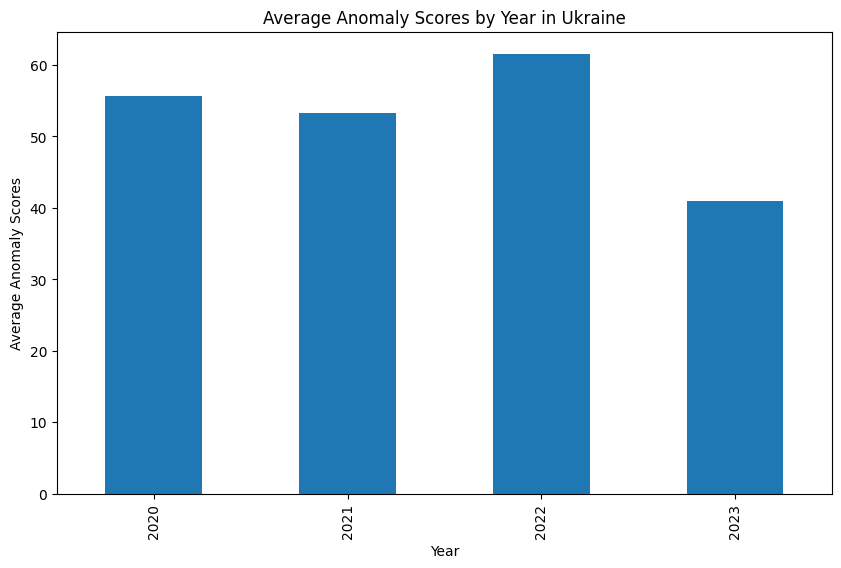

In [12]:
avg_scores_by_year_UA.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Average Anomaly Scores')
plt.title('Average Anomaly Scores by Year in Ukraine')
plt.show()

In [13]:
severity_counts_by_year = new_df[new_df['target_location'] == 'IL'].groupby(new_df['Timestamp'].apply(lambda x: x.year))['Severity Level'].value_counts()
severity_counts_by_year

Timestamp  Severity Level
2020       Low               12
           Medium            11
           High               7
2021       High              12
           Low                8
           Medium             7
2022       Low               13
           Medium             9
           High               6
2023       Low                9
           Medium             7
           High               4
Name: count, dtype: int64

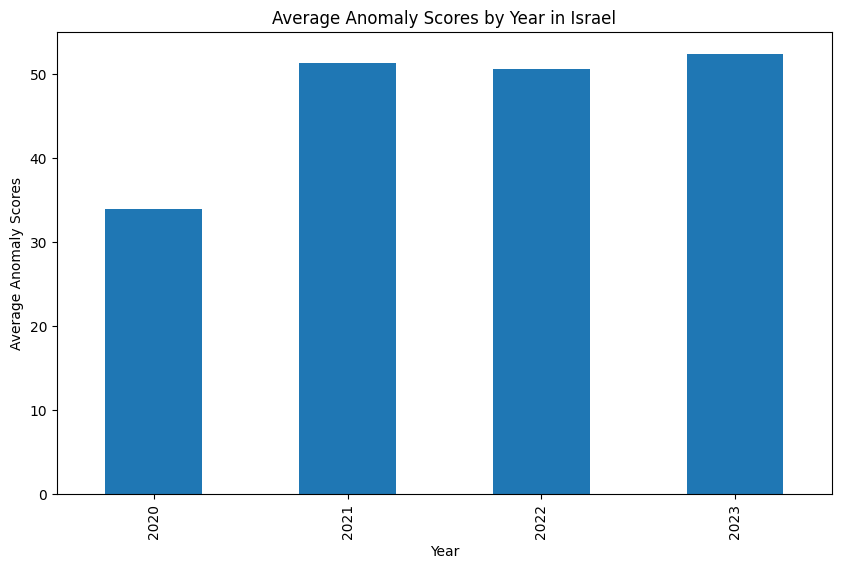

In [14]:
avg_scores_by_year_IL.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Average Anomaly Scores')
plt.title('Average Anomaly Scores by Year in Israel')
plt.show()


In [15]:
counts_by_year_IR = new_df[new_df['source_location'] == 'IR']['Timestamp'].apply(lambda x: x.year).value_counts()
print(counts_by_year_IR)
avg_scores_by_year_IR = new_df[new_df['source_location'] == 'IR'].groupby(new_df['Timestamp'].apply(lambda x: x.year))['Anomaly Scores'].mean()
print(avg_scores_by_year_IR)

Timestamp
2021    43
2020    35
2022    31
2023    20
Name: count, dtype: int64
Timestamp
2020    53.421714
2021    47.377442
2022    50.968387
2023    53.991500
Name: Anomaly Scores, dtype: float64


In [16]:
date_to_compare = pd.to_datetime('2022-02-01')
new_df['Timestamp_date'] = pd.to_datetime(new_df['Timestamp'])
filtered_df = new_df[(new_df['Timestamp_date'] >= date_to_compare) & (new_df['target_location'] == 'UA')]
filtered_df

,Timestamp,source_location,target_location,Anomaly Scores,Attack Type,Severity Level,source_location_full_name,target_location_full_name,formatted_timestamp,Timestamp_date
574,2022-11-28,SE,UA,79.19,DDoS,Low,Sweden,Ukraine,2022 Nov 28,2022-11-28
1605,2023-03-29,SG,UA,2.19,DDoS,Medium,Singapore,Ukraine,2023 Mar 29,2023-03-29
2586,2022-08-05,BR,UA,18.60,DDoS,High,Brazil,Ukraine,2022 Aug 05,2022-08-05
2819,2022-08-20,US,UA,73.85,DDoS,Medium,United States,Ukraine,2022 Aug 20,2022-08-20
3731,2023-06-19,FR,UA,85.97,Intrusion,Low,France,Ukraine,2023 Jun 19,2023-06-19
4044,2022-06-14,US,UA,96.94,DDoS,Medium,United States,Ukraine,2022 Jun 14,2022-06-14
4193,2023-03-23,US,UA,90.43,Malware,Low,United States,Ukraine,2023 Mar 23,2023-03-23
4521,2023-08-25,US,UA,49.16,Malware,Medium,United States,Ukraine,2023 Aug 25,2023-08-25
5412,2022-09-23,US,UA,25.84,Intrusion,Medium,United States,Ukraine,2022 Sep 23,2022-09-23
6223,2022-07-30,JP,UA,79.01,Intrusion,Low,Japan,Ukraine,2022 Jul 30,2022-07-30


In [17]:
yearly_counts = filtered_df['Timestamp'].apply(lambda x: x.year).value_counts()

print(yearly_counts)

Timestamp
2022    28
2023    20
Name: count, dtype: int64


In [18]:
avg_scores_by_year_month = new_df[new_df['target_location'] == 'IL'].groupby(new_df['formatted_timestamp'].apply(lambda x: tuple(x.split()[0:2])))['Anomaly Scores'].mean()
avg_scores_by_year_month = avg_scores_by_year_month.sort_values(ascending=False)
print(avg_scores_by_year_month)


formatted_timestamp
(2021, Oct)    93.590000
(2021, Aug)    93.160000
(2022, Mar)    92.480000
(2020, Dec)    90.030000
(2023, Sep)    80.930000
(2022, Sep)    80.200000
(2023, Feb)    77.965000
(2021, May)    76.320000
(2021, Jan)    67.795000
(2022, Aug)    63.885000
(2023, Jul)    59.750000
(2021, Sep)    58.730000
(2022, Oct)    56.910000
(2023, Mar)    56.225000
(2020, May)    55.307500
(2021, Jun)    53.896667
(2021, Apr)    53.628000
(2021, Mar)    53.470000
(2023, Aug)    53.152000
(2023, Jun)    53.073333
(2021, Feb)    51.893333
(2022, Jun)    50.105000
(2022, May)    49.196667
(2022, Feb)    45.650000
(2023, Oct)    44.770000
(2022, Nov)    44.635000
(2022, Jan)    42.670000
(2020, Nov)    42.285000
(2023, Jan)    39.132500
(2022, Dec)    38.860000
(2020, Oct)    38.245000
(2021, Dec)    37.216667
(2020, Jun)    37.172500
(2020, Jan)    36.393333
(2022, Apr)    32.020000
(2022, Jul)    24.920000
(2020, Sep)    24.023333
(2021, Jul)    22.595000
(2020, Aug)    22.390000
(2020

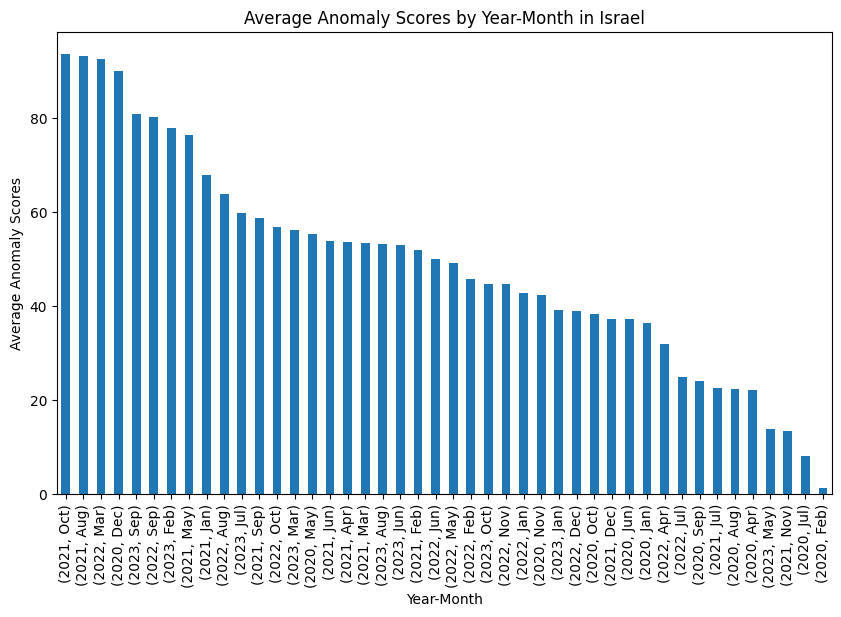

In [19]:
avg_scores_by_year_month.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year-Month')
plt.ylabel('Average Anomaly Scores')
plt.title('Average Anomaly Scores by Year-Month in Israel')
plt.show()


In [187]:
counts_by_year = new_df['formatted_timestamp'].apply(lambda x: x.split()[0]).value_counts()
print(counts_by_year)

avg_scores_by_year = new_df.groupby(new_df['formatted_timestamp'].apply(lambda x: x.split()[0]))['Anomaly Scores'].mean()
print(avg_scores_by_year)

formatted_timestamp
2022    10565
2020    10379
2021    10348
2023     7988
Name: count, dtype: int64
formatted_timestamp
2020    49.918813
2021    50.504214
2022    49.961545
2023    50.063995
Name: Anomaly Scores, dtype: float64


## Graph of Cyber Attacks

### Create Graph

In [217]:
G = nx.DiGraph()

for index, row in new_df.iterrows():
    source = row['source_location_full_name']
    target = row['target_location_full_name']
    
    if G.has_edge(source, target):
        # we added this one before, just increase the weight by one
        G[source][target]['weight'] += 1
    else:
        # new edge. add with weight=1
        G.add_edge(source, target, weight=1)

In [21]:
print(G)

DiGraph with 201 nodes and 3181 edges


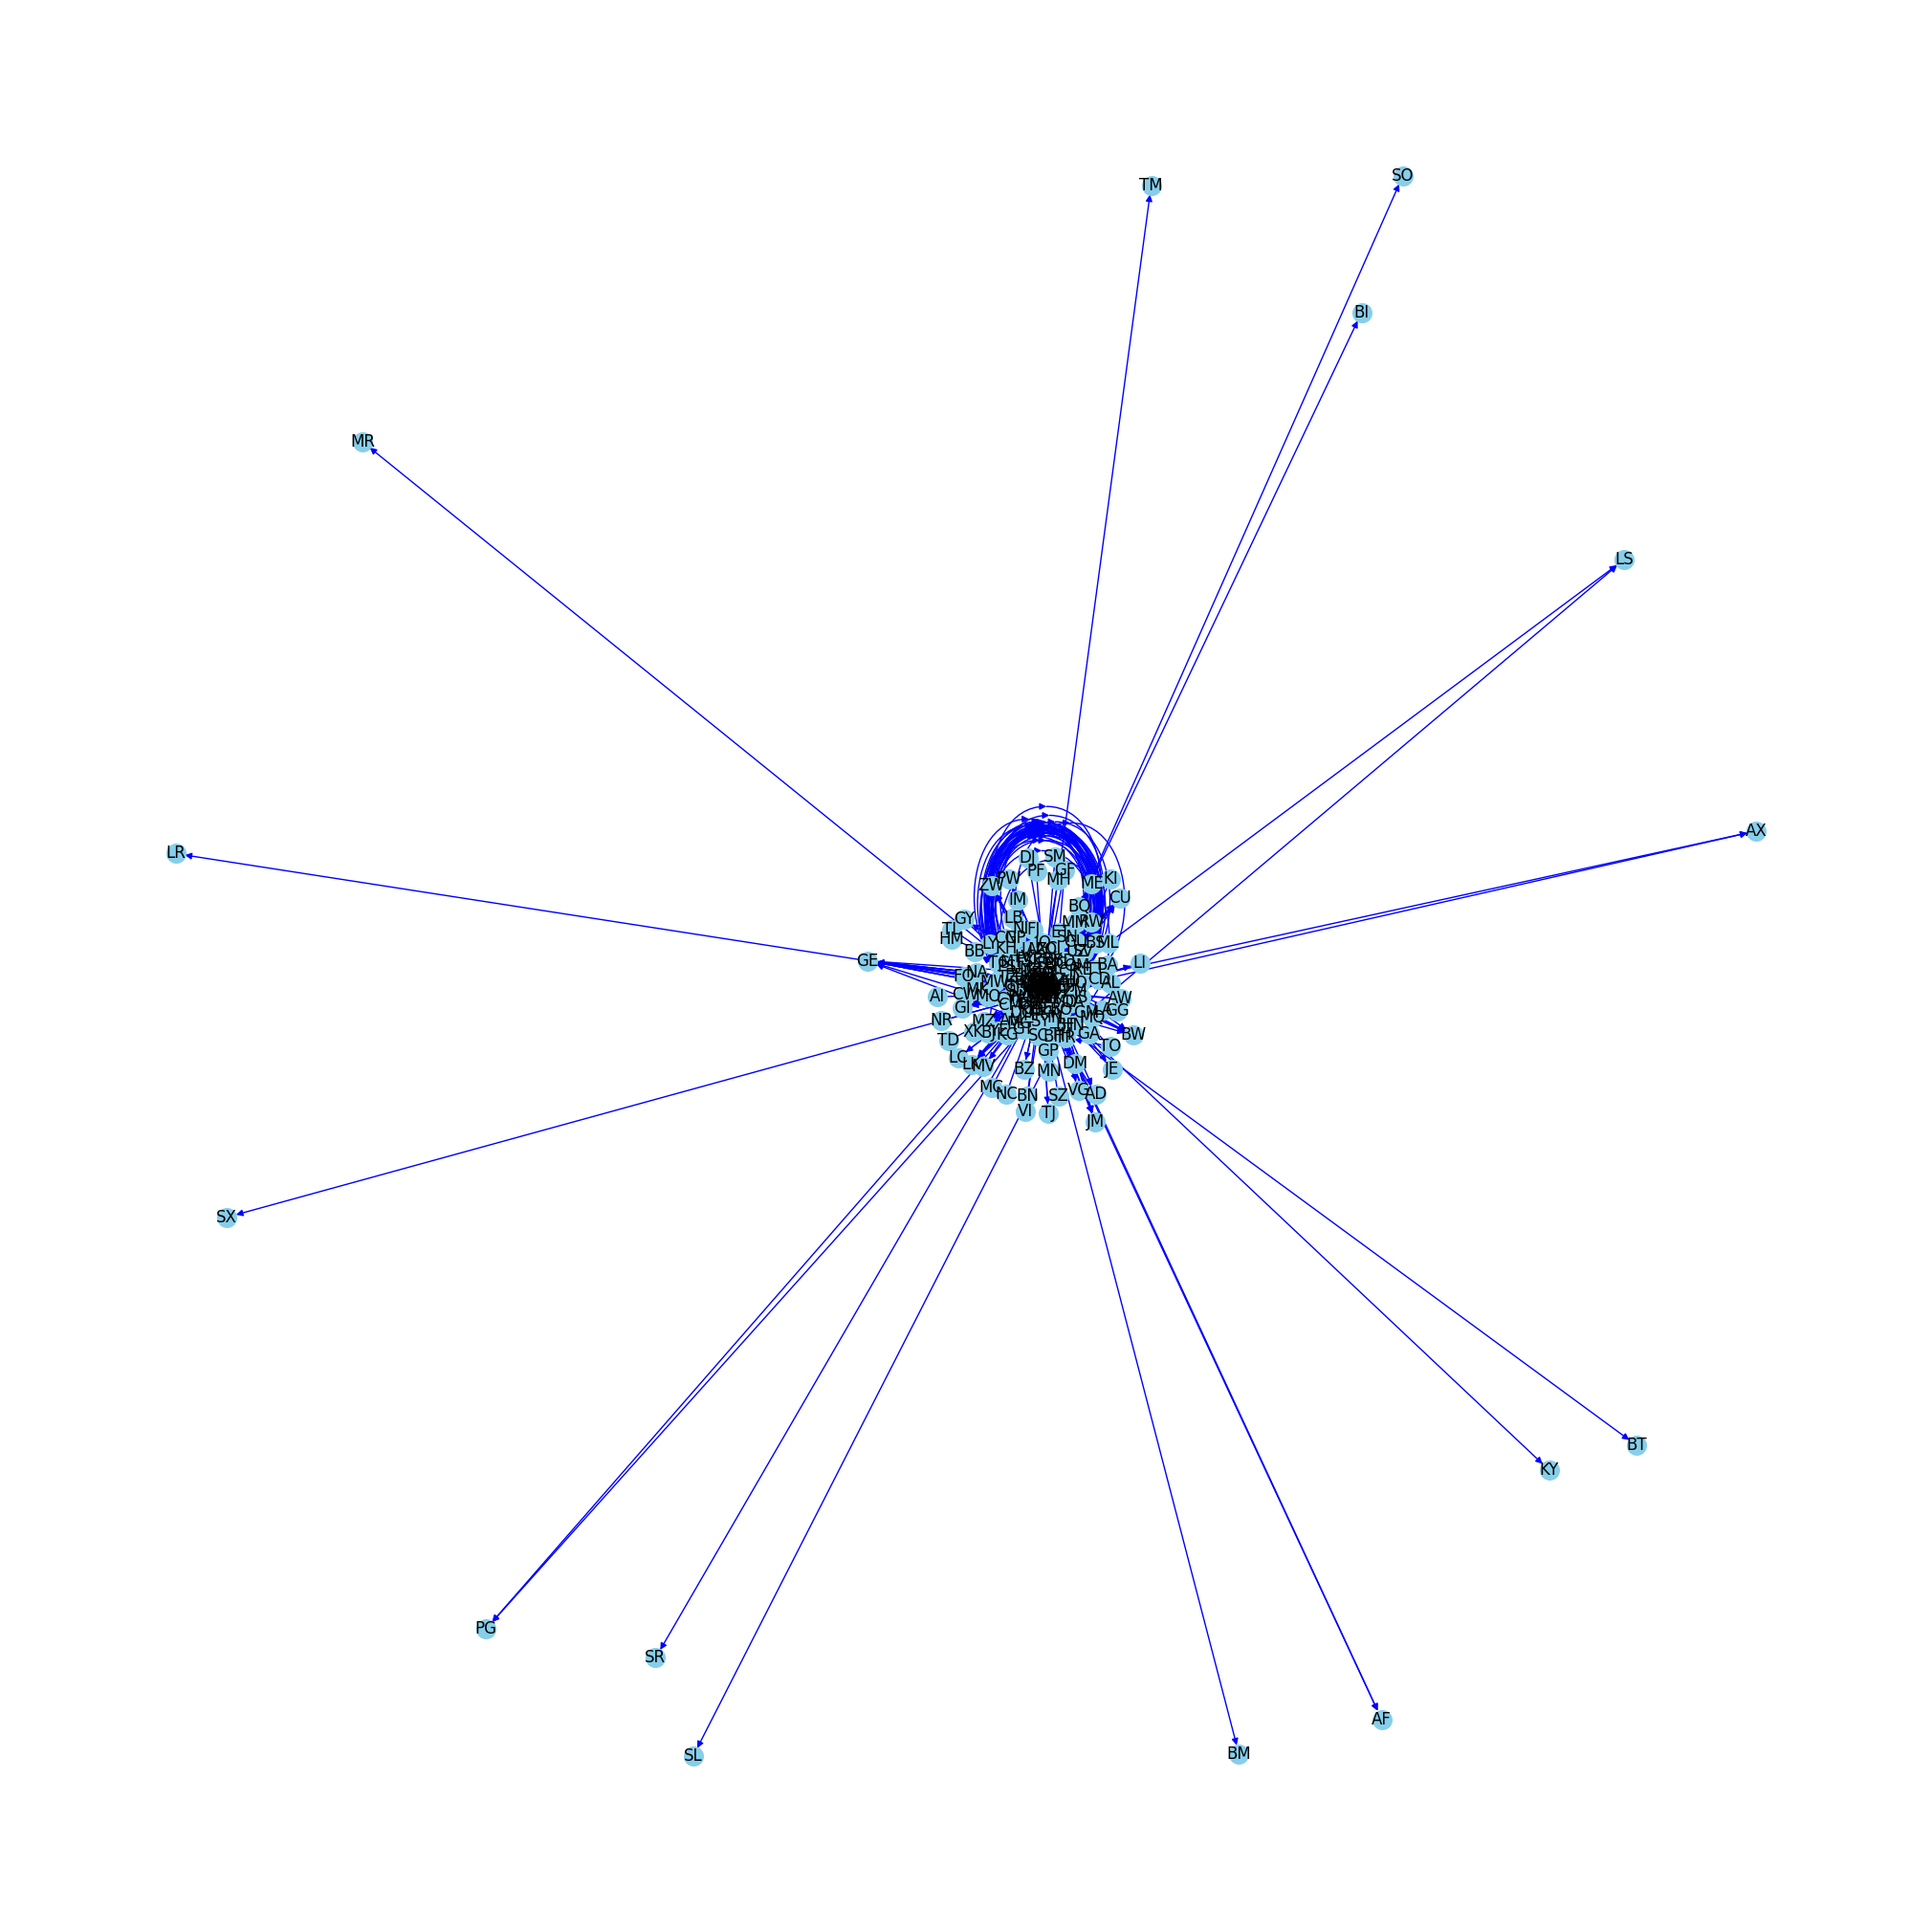

In [36]:
plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=200, edge_color='b')
plt.show()

In [122]:
def draw_predecessor_subgraph(G, node):
    # Check if the node exists in the graph
    if G.has_node(node):
        # Get all the nodes that have an edge from them to the node
        predecessors = list(G.predecessors(node))
        
        # Create a new directed graph and add only the edges that point to the node
        H = nx.DiGraph()
        H.add_node(node)
        for pred in predecessors:
            H.add_edge(pred, node, weight=G[pred][node]['weight'])  # Add weight to the edges
        
        # Plot the graph
        plt.figure(figsize=(20, 20))
        pos = nx.circular_layout(H)  # Position the nodes using a spring layout
        node_size = 6500  # Increase the node size
        edge_labels = nx.get_edge_attributes(H, 'weight')  # Get the edge weights as labels
        nx.draw_networkx_nodes(H, pos, node_color='skyblue', node_size=node_size)
        nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=node_size, edge_color='b', arrows=True)  # Draw directed edges
        nx.draw_networkx_labels(H, pos, font_color='black')
        nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels)  # Add edge labels
        plt.title(f'Graph with all the countries that attacked {node}')
        plt.show()
    else:
        print(f'{node} node does not exist in the graph.')

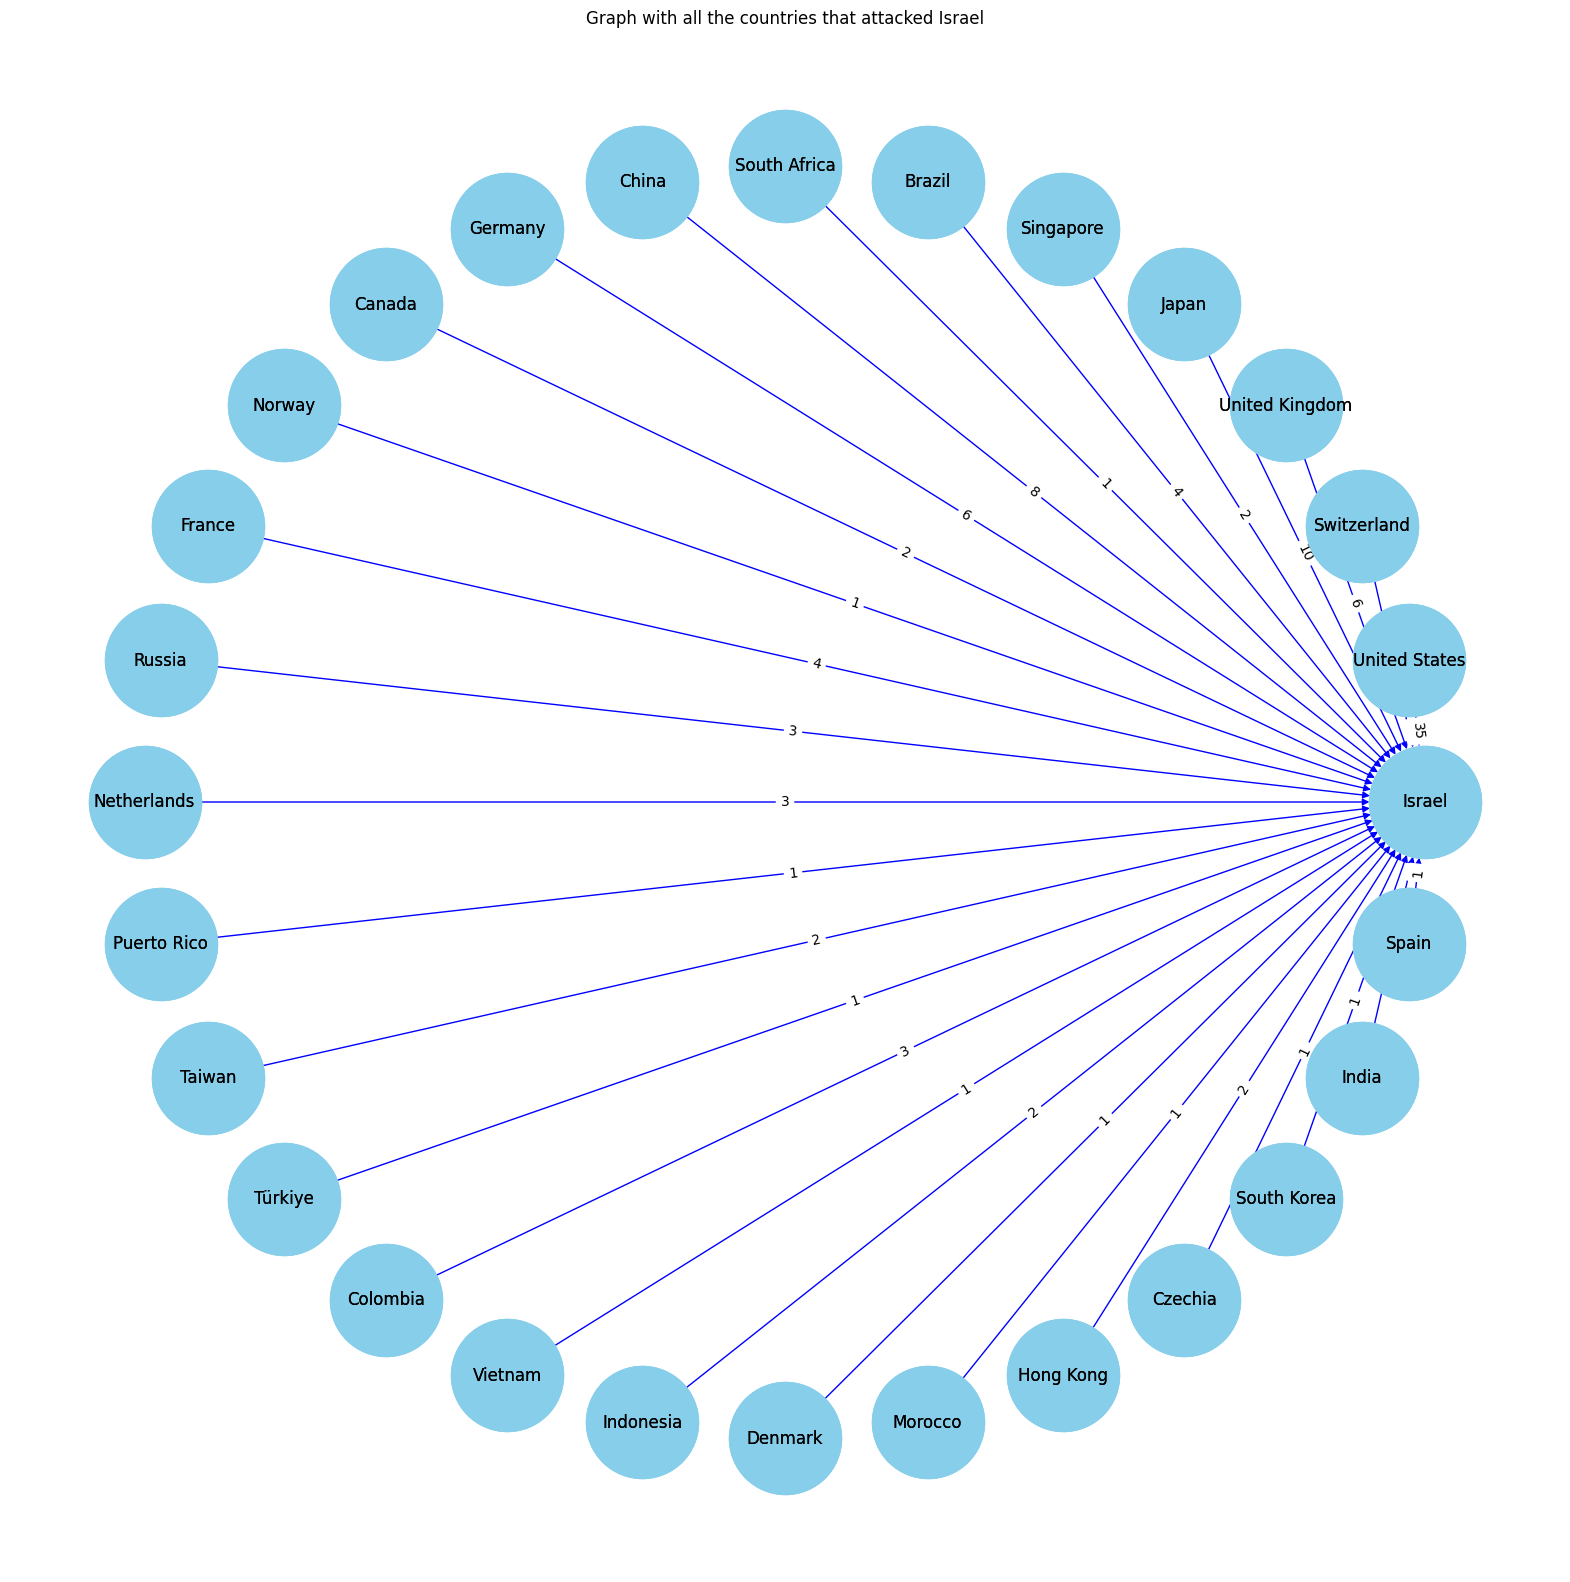

In [218]:
draw_predecessor_subgraph(G, 'Israel')

In [214]:
def draw_successor_subgraph(G, node):
    # Check if the node exists in the graph
    if G.has_node(node):
        # Get all the nodes that have an edge from the node to them
        successors = list(G.successors(node))
        
        # Create a new directed graph and add only the edges that start from the node
        H = nx.DiGraph()
        H.add_node(node)
        for succ in successors:
            H.add_edge(node, succ, weight=G[node][succ]['weight'])  # Add weight to the edges
        
        # Plot the graph
        plt.figure(figsize=(20, 20))
        pos = nx.circular_layout(H)  # Position the nodes using a spring layout
        node_size = 6500  # Increase the node size
        edge_labels = nx.get_edge_attributes(H, 'weight')  # Get the edge weights as labels
        nx.draw_networkx_nodes(H, pos, node_color='skyblue', node_size=node_size)
        nx.draw(H, pos, with_labels=True, node_color='skyblue', node_size=node_size, edge_color='b', arrows=True)  # Draw directed edges
        nx.draw_networkx_labels(H, pos, font_color='black')
        nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels)  # Add edge labels
        plt.title(f'Graph with all the countries {node} has attacked')
        plt.show()
    else:
        print(f'{node} node does not exist in the graph.')

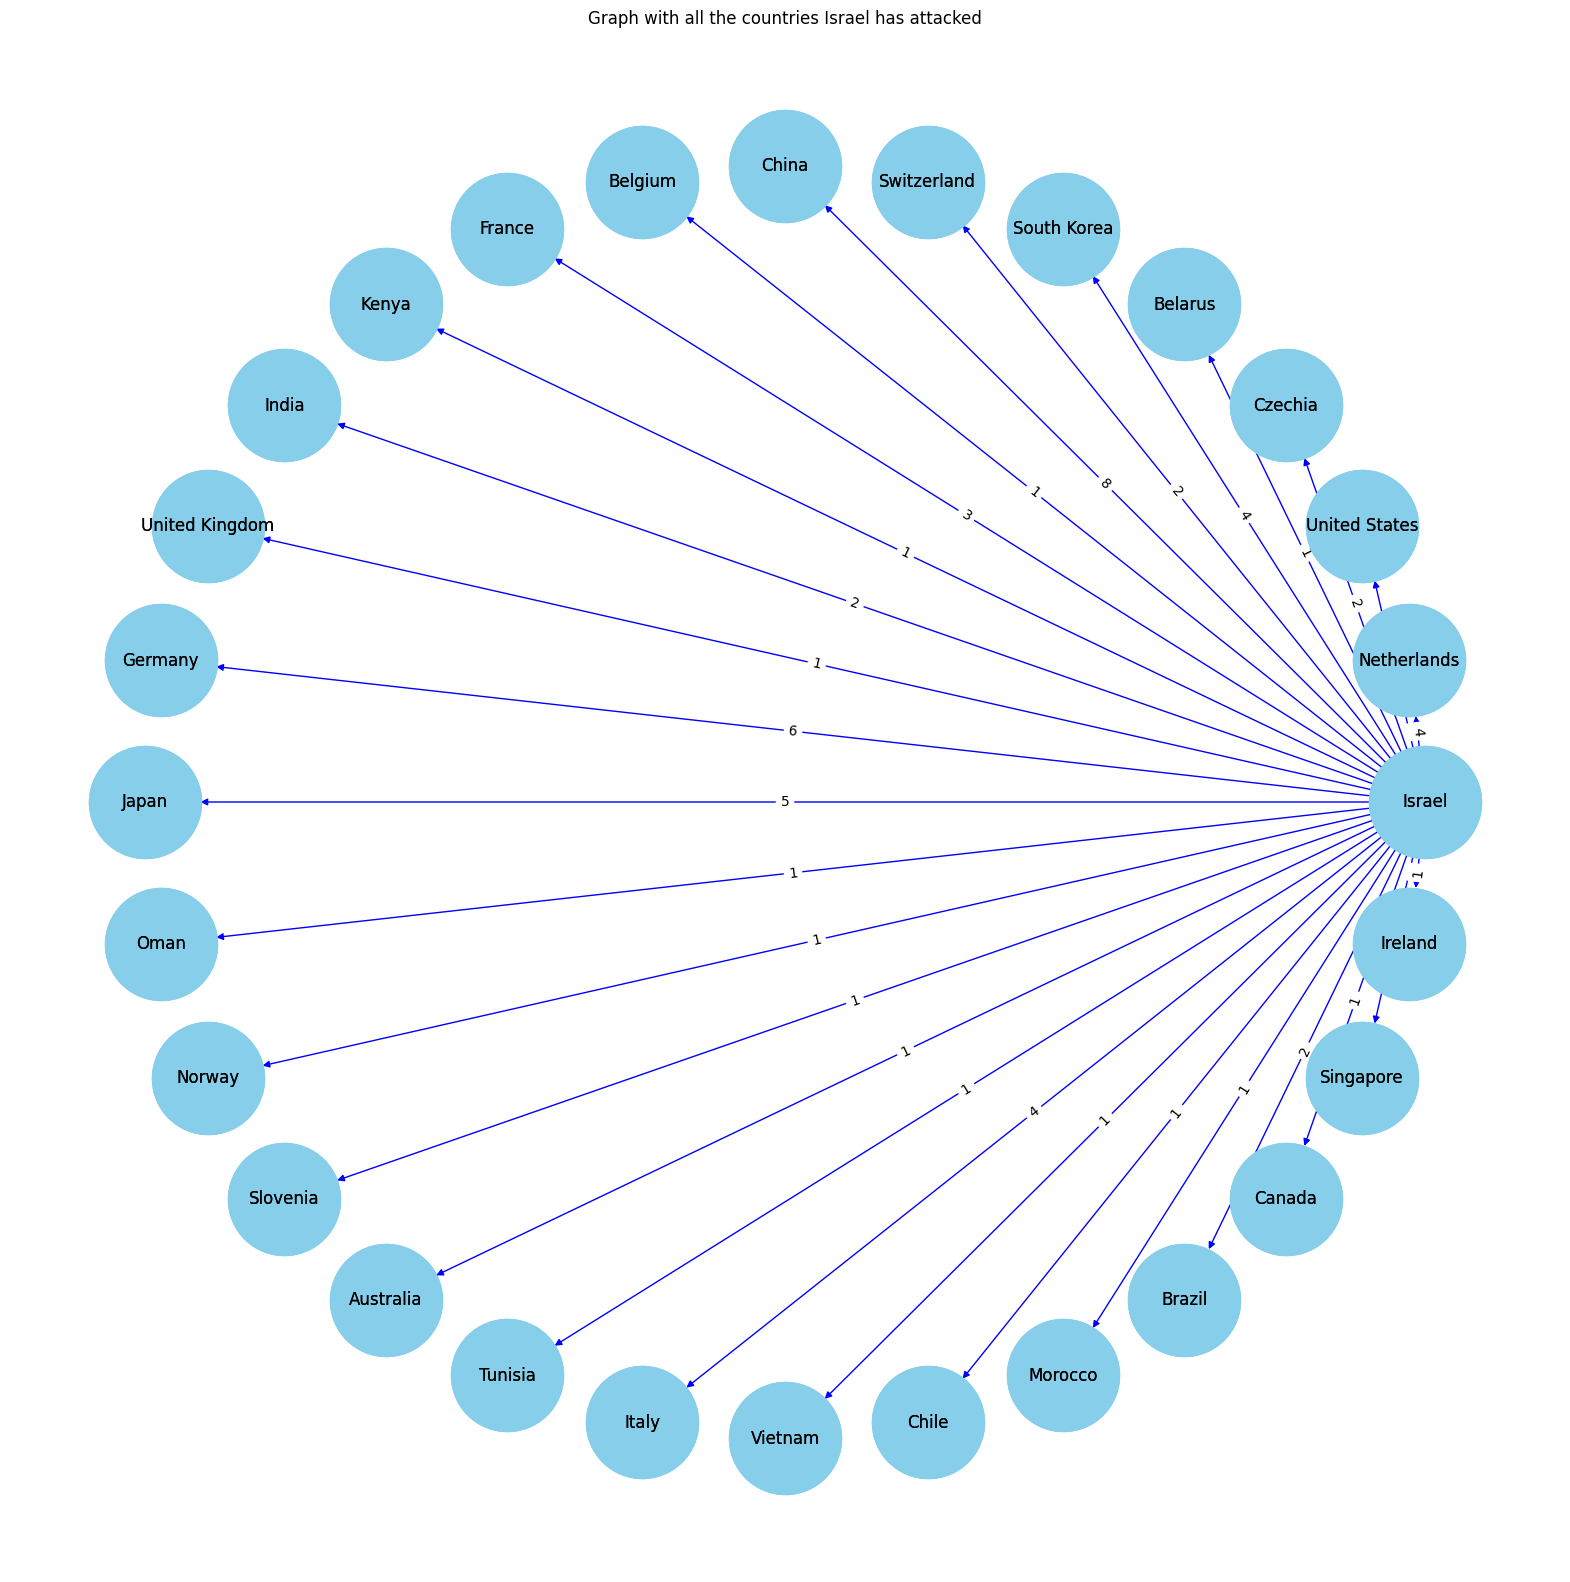

In [219]:
draw_successor_subgraph(G, 'Israel')

### Page Rank

In [223]:
# Calculate the PageRank scores with weights
pagerank = nx.pagerank(G, weight='None')

# Sort the PageRank scores in descending order
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

# Print the PageRank scores in descending order, excluding the node "Not Found"
for node, score in sorted_pagerank:
    print(f"Node: {node}, Score: {score}")


Node: United States, Score: 0.06483043284678192
Node: China, Score: 0.03786288729767836
Node: Japan, Score: 0.02721131124480035
Node: South Korea, Score: 0.022828130265798236
Node: Germany, Score: 0.02208878143929969
Node: United Kingdom, Score: 0.021640462927187368
Node: Brazil, Score: 0.021071685610405413
Node: France, Score: 0.020532446899829204
Node: Canada, Score: 0.01929667318808207
Node: Netherlands, Score: 0.016965525071463587
Node: Australia, Score: 0.016515019209583152
Node: Russia, Score: 0.016494441353984885
Node: Italy, Score: 0.015815417818101765
Node: Taiwan, Score: 0.015094148782240158
Node: India, Score: 0.014205465552876552
Node: Spain, Score: 0.013889043331492212
Node: Mexico, Score: 0.013188269240505743
Node: Switzerland, Score: 0.013100114766003867
Node: Sweden, Score: 0.013044649297112307
Node: Singapore, Score: 0.012958697825069388
Node: Indonesia, Score: 0.012465593546481798
Node: Vietnam, Score: 0.011627285074360841
Node: Poland, Score: 0.011343295614145347
Nod

In [147]:
pagerank['Israel']

0.007264137547702597

In [224]:
sorted_pagerank_df = pd.DataFrame(sorted_pagerank, columns=['country', 'pagerank'])
sorted_pagerank_df.head()

,country,pagerank
0,United States,0.064830
1,China,0.037863
2,Japan,0.027211
3,South Korea,0.022828
4,Germany,0.022089


/tmp/ipykernel_2668354/2653269378.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


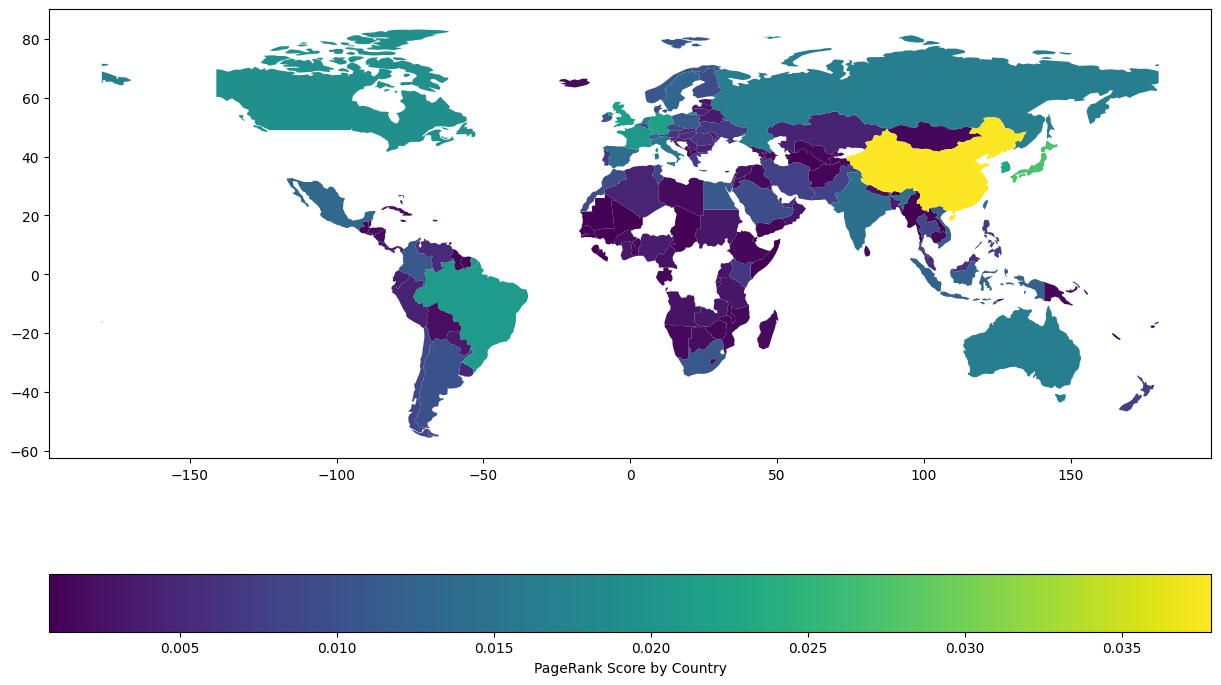

In [225]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(sorted_pagerank_df, left_on='name', right_on='country', how='left')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(column='pagerank', ax=ax, legend=True,
           legend_kwds={'label': "PageRank Score by Country",
                        'orientation': "horizontal"})
plt.show()

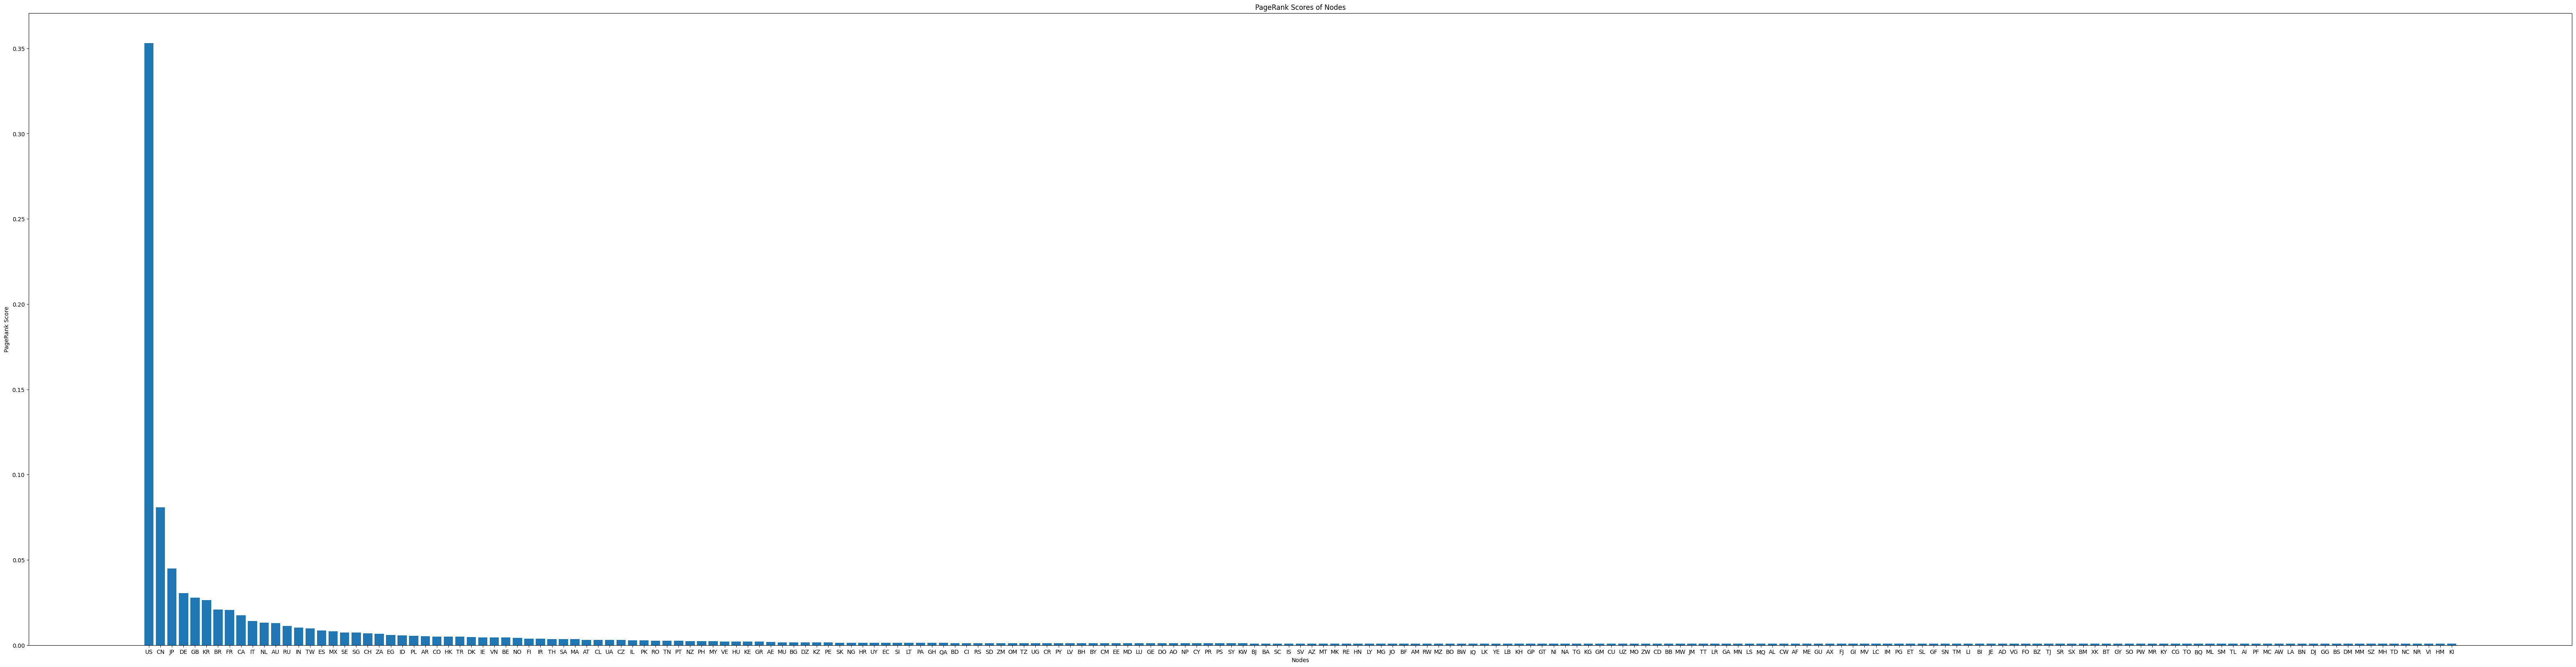

In [28]:
# Get the nodes and the PageRank scores
nodes = [node for node, score in sorted_pagerank]
scores = [score for node, score in sorted_pagerank]

plt.figure(figsize=(80, 20))

# Create a bar chart
plt.bar(nodes, scores)

plt.xlabel('Nodes')
plt.ylabel('PageRank Score')
plt.title('PageRank Scores of Nodes')

plt.show()

### Link Prediction

In [160]:
def common_countries(g,u,v):
    if not g.has_node(u) or not g.has_node(v):
        return None
    return set(g.neighbors(u)) & set(g.neighbors(v))

def find_countries_of_countries(g, v):
    "Returns a set with all the countries of countries of v that are not countries of v"
    countries_set = set(g.neighbors(v))
    countries_of_countries_set = set()
    for c in countries_set:
        countries_of_countries_set |= set(g.neighbors(c))
    countries_of_countries_set -= countries_set
    countries_of_countries_set -= {v}
    return countries_of_countries_set

def countries_measure(g,u,v):
    s = 0
    for x in find_countries_of_countries(g,u):
        for y in find_countries_of_countries(g,v):
            if g.has_edge(x,y) or x == y:
                s += 1
    return s

def total_countries(g, u, v):   
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

def jaccard_coefficient(g, u, v):
    neighbors_u = set(g.successors(u))
    neighbors_v = set(g.successors(v))
    
    intersection = len(neighbors_u & neighbors_v)
    union = len(neighbors_u | neighbors_v)
    
    if union == 0:
        return 0
    else:
        return intersection / union

def adamic_adar_index(g, u, v):
    neighbors_u = set(g.successors(u))
    neighbors_v = set(g.successors(v))
    
    common_neighbors = neighbors_u & neighbors_v
    index = sum(1 / math.log(g.out_degree(node)) for node in common_neighbors if g.out_degree(node) > 0)
    
    return index

def sum_weight_out_u(g, u):
    return sum(d.get('weight', 0) for _, _, d in g.out_edges(u, data=True))

def sum_weight_in_v(g, v):
    return sum(d.get('weight', 0) for _, _, d in g.in_edges(v, data=True))

def avg_weight_out_u(g, u):
    out_degree = g.out_degree(u)
    return sum(d.get('weight', 0) for _, _, d in g.out_edges(u, data=True)) / out_degree if out_degree > 0 else 0

def avg_weight_in_v(g, v):
    in_degree = g.in_degree(v)
    return sum(d.get('weight', 0) for _, _, d in g.in_edges(v, data=True)) / in_degree if in_degree > 0 else 0

In [162]:
s = sum(d.get('weight', 0) for _, _, d in G.out_edges('Israel', data=True))
s

95

In [163]:
for u, v, d in G.out_edges('Israel', data=True):
    if 'weight' not in d:
        print(f"Edge ({u}, {v}) does not have a 'weight' attribute.")

In [164]:
common_countries(G, 'Iran', 'Israel')

{'Australia',
 'Brazil',
 'Canada',
 'China',
 'France',
 'Germany',
 'India',
 'Japan',
 'Netherlands',
 'South Korea',
 'United Kingdom',
 'United States',
 'Vietnam'}

In [165]:
def select_random_existing_links(g, n):
    l =list(g.edges())
    random.shuffle(l)
    return l[:n]

def select_random_non_existing_links(g, n):
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        u = random.choice(v_list)
        v = random.choice(v_list)
        if g.has_edge(u,v) or (u,v) in select_links and u == v:
            continue
        else:
            select_links.add((u,v))
    return list(select_links)

In [166]:
postive_links = select_random_existing_links(G,3181)
negative_links = select_random_non_existing_links(G,3181)

In [167]:
def get_features_dict(g,u,v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'in_degree_v': g.in_degree(v),
            'out_degree_u': g.out_degree(u),
            'total_countries': total_countries(g,u,v),
            'common_countries': len(common_countries(g,u,v)),
            'jaccard_coefficient': jaccard_coefficient(g,u,v),
            'adamic_adar_index': adamic_adar_index(g,u,v),
            'page_rank_v' : pagerank[v],
            'page_rank_u' : pagerank[u],
            'countries_measure': countries_measure(g,u,v),
            'sum_weight_out_u': sum_weight_out_u(g, u),
            'sum_weight_in_v': sum_weight_in_v(g, v),
            'avg_weight_out_u': avg_weight_out_u(g, u),
            'avg_weight_in_v': avg_weight_in_v(g, v)
        }
    except Exception as e: 
        print(e)
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None

    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

In [168]:
links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    d = get_features_dict(G,u,v )
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(G,u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)
links_features

  1%|          | 28/3181 [00:01<01:32, 33.94it/s]

float division by zero


  2%|▏         | 70/3181 [00:02<01:52, 27.61it/s]

float division by zero


  4%|▍         | 139/3181 [00:05<02:32, 19.91it/s]

float division by zero


  5%|▍         | 145/3181 [00:05<02:26, 20.73it/s]

float division by zero


  7%|▋         | 232/3181 [00:09<01:37, 30.25it/s]

float division by zero
float division by zero


  8%|▊         | 248/3181 [00:10<01:41, 28.95it/s]

float division by zero


 10%|▉         | 314/3181 [00:12<01:53, 25.26it/s]

float division by zero


 12%|█▏        | 383/3181 [00:15<01:45, 26.43it/s]

float division by zero
float division by zero


 14%|█▍        | 455/3181 [00:18<01:50, 24.61it/s]

float division by zero


 15%|█▌        | 492/3181 [00:20<01:42, 26.18it/s]

float division by zero


 17%|█▋        | 538/3181 [00:21<01:36, 27.38it/s]

float division by zero


 18%|█▊        | 567/3181 [00:23<01:46, 24.55it/s]

float division by zero


 18%|█▊        | 584/3181 [00:23<01:38, 26.46it/s]

float division by zero


 19%|█▉        | 611/3181 [00:24<01:32, 27.69it/s]

float division by zero


 21%|██        | 662/3181 [00:26<01:26, 29.20it/s]

float division by zero


 26%|██▌       | 817/3181 [00:32<01:32, 25.50it/s]

float division by zero


 27%|██▋       | 854/3181 [00:34<01:57, 19.86it/s]

float division by zero


 28%|██▊       | 882/3181 [00:36<02:04, 18.47it/s]

float division by zero


 29%|██▉       | 920/3181 [00:37<01:34, 23.92it/s]

float division by zero


 30%|██▉       | 940/3181 [00:38<01:26, 26.04it/s]

float division by zero


 32%|███▏      | 1010/3181 [00:41<01:29, 24.25it/s]

float division by zero


 34%|███▍      | 1088/3181 [00:44<01:14, 28.16it/s]

float division by zero


 36%|███▌      | 1152/3181 [00:47<01:01, 32.83it/s]

float division by zero
float division by zero


 38%|███▊      | 1223/3181 [00:50<01:14, 26.22it/s]

float division by zero


 40%|███▉      | 1265/3181 [00:51<01:00, 31.86it/s]

float division by zero


 40%|███▉      | 1269/3181 [00:51<00:59, 32.06it/s]

float division by zero


 43%|████▎     | 1383/3181 [00:56<01:06, 27.11it/s]

float division by zero


 47%|████▋     | 1494/3181 [01:01<01:04, 26.22it/s]

float division by zero


 47%|████▋     | 1509/3181 [01:01<01:03, 26.44it/s]

float division by zero


 48%|████▊     | 1526/3181 [01:02<00:54, 30.44it/s]

float division by zero


 49%|████▉     | 1563/3181 [01:03<00:59, 27.21it/s]

float division by zero


 50%|████▉     | 1590/3181 [01:04<00:56, 28.27it/s]

float division by zero


 50%|█████     | 1603/3181 [01:05<01:07, 23.31it/s]

float division by zero


 54%|█████▍    | 1732/3181 [01:10<00:54, 26.44it/s]

float division by zero
float division by zero


 56%|█████▌    | 1772/3181 [01:11<00:41, 34.33it/s]

float division by zero


 57%|█████▋    | 1824/3181 [01:13<00:47, 28.81it/s]

float division by zero


 58%|█████▊    | 1847/3181 [01:14<01:01, 21.57it/s]

float division by zero


 59%|█████▉    | 1877/3181 [01:16<00:48, 26.80it/s]

float division by zero


 59%|█████▉    | 1890/3181 [01:16<00:46, 27.82it/s]

float division by zero


 60%|█████▉    | 1894/3181 [01:16<00:44, 28.77it/s]

float division by zero


 61%|██████    | 1947/3181 [01:18<00:39, 31.38it/s]

float division by zero


 63%|██████▎   | 2000/3181 [01:20<00:49, 23.83it/s]

float division by zero


 64%|██████▎   | 2027/3181 [01:21<00:39, 29.31it/s]

float division by zero
float division by zero


 69%|██████▉   | 2210/3181 [01:29<00:34, 28.47it/s]

float division by zero
float division by zero


 70%|███████   | 2229/3181 [01:29<00:34, 27.33it/s]

float division by zero


 71%|███████▏  | 2270/3181 [01:31<00:36, 25.24it/s]

float division by zero


 72%|███████▏  | 2281/3181 [01:31<00:31, 28.36it/s]

float division by zero


 73%|███████▎  | 2320/3181 [01:33<00:33, 25.86it/s]

float division by zero


 75%|███████▌  | 2397/3181 [01:36<00:27, 28.59it/s]

float division by zero


 76%|███████▌  | 2413/3181 [01:37<00:25, 30.02it/s]

float division by zero


 77%|███████▋  | 2440/3181 [01:38<00:27, 26.76it/s]

float division by zero


 78%|███████▊  | 2497/3181 [01:40<00:27, 24.66it/s]

float division by zero


 79%|███████▉  | 2516/3181 [01:41<00:24, 26.72it/s]

float division by zero


 80%|███████▉  | 2536/3181 [01:42<00:21, 30.14it/s]

float division by zero


 80%|████████  | 2545/3181 [01:42<00:21, 29.39it/s]

float division by zero


 81%|████████  | 2574/3181 [01:43<00:24, 24.64it/s]

float division by zero


 82%|████████▏ | 2600/3181 [01:44<00:19, 30.01it/s]

float division by zero


 83%|████████▎ | 2639/3181 [01:46<00:21, 25.41it/s]

float division by zero


 88%|████████▊ | 2800/3181 [01:53<00:15, 25.15it/s]

float division by zero


 91%|█████████ | 2885/3181 [01:56<00:11, 24.79it/s]

float division by zero


 91%|█████████ | 2892/3181 [01:57<00:11, 24.57it/s]

float division by zero


 93%|█████████▎| 2970/3181 [02:00<00:08, 25.84it/s]

float division by zero


 95%|█████████▍| 3019/3181 [02:02<00:05, 27.66it/s]

float division by zero


 97%|█████████▋| 3093/3181 [02:05<00:02, 30.63it/s]

float division by zero


 98%|█████████▊| 3128/3181 [02:06<00:02, 24.79it/s]

float division by zero


100%|█████████▉| 3174/3181 [02:09<00:00, 22.49it/s]

float division by zero


100%|██████████| 3181/3181 [01:19<00:00, 39.95it/s]


[{'in_degree_v': 94,
  'out_degree_u': 5,
  'total_countries': 91,
  'common_countries': 5,
  'jaccard_coefficient': 0.054945054945054944,
  'adamic_adar_index': 1.127662896932192,
  'page_rank_v': 0.02721131124480035,
  'page_rank_u': 0.002393951391922431,
  'countries_measure': 280,
  'sum_weight_out_u': 8,
  'sum_weight_in_v': 2114,
  'avg_weight_out_u': 1.6,
  'avg_weight_in_v': 22.48936170212766,
  'class': True},
 {'in_degree_v': 73,
  'out_degree_u': 105,
  'total_countries': 113,
  'common_countries': 62,
  'jaccard_coefficient': 0.5486725663716814,
  'adamic_adar_index': 18.59177436999349,
  'page_rank_v': 0.020532446899829204,
  'page_rank_u': 0.03786288729767836,
  'countries_measure': 72,
  'sum_weight_out_u': 3537,
  'sum_weight_in_v': 798,
  'avg_weight_out_u': 33.68571428571428,
  'avg_weight_in_v': 10.931506849315069,
  'class': True},
 {'in_degree_v': 40,
  'out_degree_u': 62,
  'total_countries': 69,
  'common_countries': 31,
  'jaccard_coefficient': 0.449275362318840

In [170]:
link_prediction_df = pd.DataFrame.from_records(links_features) 
link_prediction_df

,in_degree_v,out_degree_u,total_countries,common_countries,jaccard_coefficient,adamic_adar_index,page_rank_v,page_rank_u,countries_measure,sum_weight_out_u,sum_weight_in_v,avg_weight_out_u,avg_weight_in_v,class
0,94,5,91,5,0.054945,1.127663,0.027211,0.002394,280,8,2114,1.600000,22.489362,True
1,73,105,113,62,0.548673,18.591774,0.020532,0.037863,72,3537,798,33.685714,10.931507,True
2,40,62,69,31,0.449275,8.004006,0.010852,0.015815,231,550,174,8.870968,4.350000,True
3,44,54,61,33,0.540984,8.648557,0.011627,0.015094,287,367,176,6.796296,4.000000,True
4,22,7,26,4,0.153846,0.866340,0.006830,0.004725,1495,20,73,2.857143,3.318182,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6285,29,2,27,1,0.037037,0.199311,0.007965,0.001489,1640,0,0,0.000000,0.000000,False
6286,1,1,2,0,0.000000,0.000000,0.001186,0.000821,2771,0,0,0.000000,0.000000,False
6287,1,9,9,1,0.111111,0.199311,0.001075,0.002713,2567,0,0,0.000000,0.000000,False
6288,0,43,43,1,0.023256,0.225692,0.000821,0.010903,945,0,0,0.000000,0.000000,False


In [172]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2, 3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
}

train, test = train_test_split(link_prediction_df, test_size=0.2)
y_train, y_test = train['class'], test['class']
X_train, X_test = train.drop('class', axis=1), test.drop('class', axis=1)

# Initialize the XGBClassifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', tree_method='hist')

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Train a new model using the best parameters
xgb_classifier_best = xgb.XGBClassifier(**best_parameters)
xgb_classifier_best.fit(X_train, y_train)

# Predict the test set results
y_predict = xgb_classifier_best.predict(X_test)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=1; total time=   0.1s
[CV] END colsample_b

In [173]:
y_test

269      True
6268    False
1677     True
4378    False
1066     True
        ...  
3059     True
572      True
1231     True
1525     True
1211     True
Name: class, Length: 1258, dtype: bool

In [174]:
print(accuracy_score(y_test,y_predict), roc_auc_score(y_test,y_predict))

0.9952305246422893 0.9951787551732943


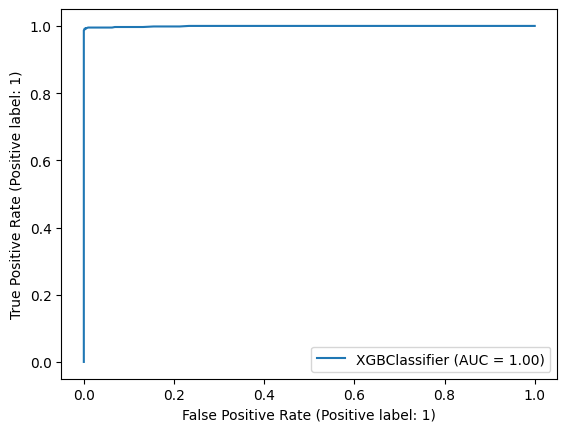

In [176]:
RocCurveDisplay.from_estimator(xgb_classifier_best, X_test, y_test)

In [177]:
xgb_classifier_best.predict_proba(X_test)

array([[0.00400698, 0.995993  ],
       [0.99335307, 0.00664692],
       [0.004076  , 0.995924  ],
       ...,
       [0.00400698, 0.995993  ],
       [0.00400698, 0.995993  ],
       [0.00447774, 0.99552226]], dtype=float32)

In [178]:
def get_random_countries_of_countries(g, v, max_tries=100):
    for i in range(max_tries):
        neighbors_v = list(g.neighbors(v))
        if not neighbors_v:
            return None
        u = random.choice(neighbors_v)
        
        neighbors_u = list(g.neighbors(u))
        if not neighbors_u:
            return None
        x = random.choice(neighbors_u)
        
        if not g.has_edge(v,x):
            return x
    return None
    
def select_random_non_existing_links_distance_2(g, n):
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        v = random.choice(v_list)
        u = get_random_countries_of_countries(g, v)
        if u is None:
            continue
        select_links.add((v,u))
    return list(select_links)

negative_links = select_random_non_existing_links_distance_2(G, 3181)
len(negative_links)

3181

In [179]:
links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    d = get_features_dict(G,u,v )
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(G,u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)
    
df2 = pd.DataFrame.from_records(links_features) 
df2

  1%|          | 28/3181 [00:01<01:49, 28.71it/s]

float division by zero


  2%|▏         | 68/3181 [00:02<01:59, 25.97it/s]

float division by zero


  4%|▍         | 139/3181 [00:05<02:00, 25.34it/s]

float division by zero


  5%|▍         | 146/3181 [00:06<02:00, 25.12it/s]

float division by zero


  7%|▋         | 233/3181 [00:09<01:39, 29.57it/s]

float division by zero
float division by zero


  8%|▊         | 250/3181 [00:10<01:39, 29.41it/s]

float division by zero


 10%|▉         | 314/3181 [00:12<01:55, 24.77it/s]

float division by zero


 12%|█▏        | 383/3181 [00:15<01:48, 25.73it/s]

float division by zero
float division by zero


 14%|█▍        | 455/3181 [00:18<01:51, 24.39it/s]

float division by zero


 15%|█▌        | 491/3181 [00:20<01:36, 27.89it/s]

float division by zero


 17%|█▋        | 538/3181 [00:21<01:37, 27.21it/s]

float division by zero


 18%|█▊        | 568/3181 [00:23<01:36, 27.05it/s]

float division by zero


 18%|█▊        | 584/3181 [00:23<01:38, 26.39it/s]

float division by zero


 19%|█▉        | 611/3181 [00:24<01:33, 27.60it/s]

float division by zero


 21%|██        | 662/3181 [00:26<01:26, 29.12it/s]

float division by zero


 26%|██▌       | 818/3181 [00:32<01:38, 24.11it/s]

float division by zero


 27%|██▋       | 855/3181 [00:34<01:44, 22.29it/s]

float division by zero


 28%|██▊       | 884/3181 [00:35<01:24, 27.03it/s]

float division by zero


 29%|██▉       | 920/3181 [00:37<01:36, 23.35it/s]

float division by zero


 30%|██▉       | 940/3181 [00:37<01:20, 27.76it/s]

float division by zero


 32%|███▏      | 1010/3181 [00:40<01:32, 23.55it/s]

float division by zero


 34%|███▍      | 1089/3181 [00:45<01:40, 20.86it/s]

float division by zero


 36%|███▌      | 1150/3181 [00:47<01:07, 30.11it/s]

float division by zero
float division by zero


 38%|███▊      | 1223/3181 [00:50<01:17, 25.25it/s]

float division by zero


 40%|███▉      | 1260/3181 [00:52<01:10, 27.30it/s]

float division by zero


 40%|███▉      | 1269/3181 [00:52<00:59, 32.22it/s]

float division by zero


 43%|████▎     | 1383/3181 [00:57<01:06, 27.11it/s]

float division by zero


 47%|████▋     | 1491/3181 [01:01<01:35, 17.77it/s]

float division by zero


 47%|████▋     | 1507/3181 [01:02<01:12, 23.13it/s]

float division by zero


 48%|████▊     | 1525/3181 [01:03<01:06, 25.09it/s]

float division by zero


 49%|████▉     | 1564/3181 [01:04<00:58, 27.63it/s]

float division by zero


 50%|████▉     | 1590/3181 [01:05<00:56, 28.33it/s]

float division by zero


 50%|█████     | 1603/3181 [01:06<00:59, 26.55it/s]

float division by zero


 54%|█████▍    | 1732/3181 [01:11<00:56, 25.71it/s]

float division by zero
float division by zero


 56%|█████▌    | 1771/3181 [01:12<00:42, 33.43it/s]

float division by zero


 57%|█████▋    | 1825/3181 [01:15<00:51, 26.57it/s]

float division by zero


 58%|█████▊    | 1847/3181 [01:15<00:50, 26.36it/s]

float division by zero


 59%|█████▉    | 1877/3181 [01:17<00:48, 27.01it/s]

float division by zero


 59%|█████▉    | 1890/3181 [01:17<00:46, 27.69it/s]

float division by zero


 60%|█████▉    | 1894/3181 [01:17<00:44, 28.67it/s]

float division by zero


 61%|██████    | 1946/3181 [01:19<00:41, 29.46it/s]

float division by zero


 63%|██████▎   | 2000/3181 [01:21<00:48, 24.17it/s]

float division by zero


 64%|██████▎   | 2027/3181 [01:22<00:39, 28.96it/s]

float division by zero
float division by zero


 69%|██████▉   | 2210/3181 [01:30<00:33, 28.71it/s]

float division by zero
float division by zero


 70%|███████   | 2229/3181 [01:30<00:34, 27.20it/s]

float division by zero


 71%|███████▏  | 2270/3181 [01:32<00:36, 24.80it/s]

float division by zero


 72%|███████▏  | 2281/3181 [01:32<00:31, 28.37it/s]

float division by zero


 73%|███████▎  | 2320/3181 [01:34<00:33, 25.88it/s]

float division by zero


 75%|███████▌  | 2399/3181 [01:37<00:28, 27.20it/s]

float division by zero


 76%|███████▌  | 2413/3181 [01:38<00:26, 29.31it/s]

float division by zero


 77%|███████▋  | 2440/3181 [01:39<00:27, 26.72it/s]

float division by zero


 78%|███████▊  | 2497/3181 [01:41<00:26, 25.54it/s]

float division by zero


 79%|███████▉  | 2516/3181 [01:42<00:25, 26.53it/s]

float division by zero


 80%|███████▉  | 2536/3181 [01:43<00:21, 29.99it/s]

float division by zero


 80%|████████  | 2545/3181 [01:43<00:21, 29.39it/s]

float division by zero


 81%|████████  | 2574/3181 [01:44<00:24, 24.63it/s]

float division by zero


 82%|████████▏ | 2600/3181 [01:45<00:19, 30.08it/s]

float division by zero


 83%|████████▎ | 2639/3181 [01:47<00:21, 25.57it/s]

float division by zero


 88%|████████▊ | 2800/3181 [01:54<00:15, 25.26it/s]

float division by zero


 91%|█████████ | 2886/3181 [01:57<00:12, 24.16it/s]

float division by zero


 91%|█████████ | 2893/3181 [01:57<00:12, 23.31it/s]

float division by zero


 93%|█████████▎| 2970/3181 [02:01<00:07, 26.82it/s]

float division by zero


 95%|█████████▍| 3019/3181 [02:02<00:05, 27.67it/s]

float division by zero


 97%|█████████▋| 3093/3181 [02:05<00:02, 30.17it/s]

float division by zero


 98%|█████████▊| 3128/3181 [02:07<00:02, 24.69it/s]

float division by zero


100%|█████████▉| 3174/3181 [02:09<00:00, 22.36it/s]

float division by zero


 23%|██▎       | 718/3181 [00:28<01:14, 33.08it/s]

float division by zero


 62%|██████▏   | 1965/3181 [01:14<00:40, 30.31it/s]

float division by zero


100%|██████████| 3181/3181 [02:01<00:00, 26.27it/s]


,in_degree_v,out_degree_u,total_countries,common_countries,jaccard_coefficient,adamic_adar_index,page_rank_v,page_rank_u,countries_measure,sum_weight_out_u,sum_weight_in_v,avg_weight_out_u,avg_weight_in_v,class
0,94,5,91,5,0.054945,1.127663,0.027211,0.002394,280,0,0,0.0,0.0,True
1,73,105,113,62,0.548673,18.591774,0.020532,0.037863,72,0,0,0.0,0.0,True
2,40,62,69,31,0.449275,8.004006,0.010852,0.015815,231,0,0,0.0,0.0,True
3,44,54,61,33,0.540984,8.648557,0.011627,0.015094,287,0,0,0.0,0.0,True
4,22,7,26,4,0.153846,0.866340,0.006830,0.004725,1495,0,0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6283,24,7,28,5,0.178571,1.185799,0.006447,0.001671,1364,0,0,0.0,0.0,False
6284,38,7,37,5,0.135135,1.183877,0.010020,0.001936,1065,0,0,0.0,0.0,False
6285,44,1,38,1,0.026316,0.296974,0.011343,0.001588,778,0,0,0.0,0.0,False
6286,4,53,54,1,0.018519,0.199311,0.001921,0.012959,874,0,0,0.0,0.0,False


In [180]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2, 3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
}

train, test = train_test_split(link_prediction_df, test_size=0.2)
y_train, y_test = train['class'], test['class']
X_train, X_test = train.drop('class', axis=1), test.drop('class', axis=1)

# Initialize the XGBClassifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', tree_method='hist')

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Train a new model using the best parameters
xgb_classifier_best = xgb.XGBClassifier(**best_parameters)
xgb_classifier_best.fit(X_train, y_train)

# Predict the test set results
y_predict = xgb_classifier_best.predict(X_test)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=1; total time=   0.1s
[CV] END colsample_b

In [226]:
best_parameters

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 100,
 'subsample': 1}

In [181]:
print(accuracy_score(y_test,y_predict), roc_auc_score(y_test,y_predict))

0.9992050874403816 0.9991334488734835


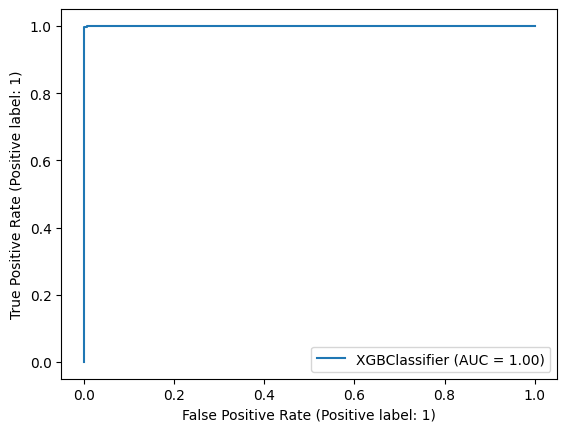

In [182]:
RocCurveDisplay.from_estimator(xgb_classifier_best, X_test, y_test)

## Global Events

In [184]:
gd = GdeltDoc()

### Create Filters

In [196]:
def convert_seendate(seendate):
    # Parse the seendate to a datetime object
    date_object = datetime.strptime(seendate, '%Y%m%dT%H%M%SZ')
    # Format the datetime object to the desired format
    formatted_date = date_object.strftime('%Y-%m-%d')
    return formatted_date

def find_articles_and_update_df(df):
    # Initialize empty lists to store the publication date of the first article and the article count
    first_pub_dates = []
    article_counts = []
    skip_country = False  # Flag to indicate skipping the country
    
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Rows"):
        if skip_country:
            break
        try:
            start_date = pd.to_datetime(row['Timestamp']).date()
            end_date = start_date + timedelta(days=14)
            
            # Construct Filters object for this row
            f = Filters(
                start_date=start_date.strftime('%Y-%m-%d'),
                end_date=end_date.strftime('%Y-%m-%d'),
                keyword=row['target_location_full_name'],
                country=[row['source_location'], row['target_location']],
                theme="CYBER_ATTACK"
            )
            
            # Introduce a delay to adhere to the API's rate limit
            sleep(5.1)  # Delay of slightly more than 5 seconds to be safe
            
            # Search for articles using the constructed filter
            articles = gd.article_search(f)
            
            # Check if articles were found
            if not articles.empty:
                # Assuming the articles DataFrame has a 'publication_date' column
                # Sort the articles by publication date and select the first
                first_pub_date = convert_seendate(articles.sort_values('seendate').iloc[0]['seendate'])
                first_pub_dates.append(first_pub_date)
                article_counts.append(len(articles))
            else:
                first_pub_dates.append(None)  # No articles found, append None
                article_counts.append(0)  # No articles found, append 0
                
        except ValueError as e:
            print(f"Skipping row due to error: {e}")
            skip_country = True  # Set flag to skip the country
            break
        
    if skip_country:
        return df, True
    
    # Add the new information to the original DataFrame
    df['first_publication_date'] = first_pub_dates
    df['article_count'] = article_counts

    return df, False

In [227]:
# Get a list of unique countries in the dataframe
unique_countries = new_df['target_location'].unique().tolist()
# Initialize an empty list to store the updated dataframes
updated_dfs = []
# Initialize a counter for successfully processed countries
successful_countries_count = 0
# Keep a set of tried countries to avoid repetition
tried_countries = set()

# Loop until 10 successful countries have been processed
while successful_countries_count < 10 and len(tried_countries) < len(unique_countries):
    # Select a random country from the unique countries list, excluding already tried ones
    remaining_countries = [country for country in unique_countries if country not in tried_countries]
    if not remaining_countries:
        # Break the loop if all countries have been tried
        print("All unique countries have been attempted.")
        break
    country = random.choice(remaining_countries)
    tried_countries.add(country)  # Add the country to the set of tried countries
    
    # Filter the dataframe to get rows where the country is the target_location_full_name
    country_df = new_df[new_df['target_location'] == country]
    print(len(country_df))
    
    # Check if the country_df has at least 5 rows
    if len(country_df) >= 5:
        # Randomly select 5 rows from the country_df
        selected_rows = country_df.sample(n=5)
        updated_df, skip_country = find_articles_and_update_df(selected_rows)
        if skip_country:
            continue  # Skip the rest of the loop and pick a new country
        else:
            updated_dfs.append(updated_df)
            successful_countries_count += 1
    else:
        # Choose a different country if the current country does not have enough rows
        continue
    
# Check if the desired number of countries was processed
if successful_countries_count < 10:
    print(f"Only {successful_countries_count} countries were processed successfully.")

# Concatenate all the updated dataframes into a single dataframe
final_df = pd.concat(updated_dfs)
final_df

7


Processing Rows: 100%|██████████| 5/5 [00:32<00:00,  6.41s/it]


1
4
72


Processing Rows:  60%|██████    | 3/5 [00:24<00:16,  8.10s/it]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
2
2
8


Processing Rows: 100%|██████████| 5/5 [00:31<00:00,  6.32s/it]


112


Processing Rows:   0%|          | 0/5 [00:05<?, ?it/s]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
7


Processing Rows:   0%|          | 0/5 [00:05<?, ?it/s]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
9


Processing Rows: 100%|██████████| 5/5 [00:31<00:00,  6.37s/it]


1
28


Processing Rows:  40%|████      | 2/5 [00:18<00:27,  9.22s/it]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
7


Processing Rows:  20%|██        | 1/5 [00:12<00:48, 12.04s/it]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
23


Processing Rows:   0%|          | 0/5 [00:05<?, ?it/s]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
16


Processing Rows:  20%|██        | 1/5 [00:11<00:47, 11.93s/it]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
219


Processing Rows: 100%|██████████| 5/5 [00:32<00:00,  6.50s/it]


1
62


Processing Rows:  80%|████████  | 4/5 [00:31<00:07,  7.90s/it]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
3
260


Processing Rows:   0%|          | 0/5 [00:05<?, ?it/s]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
73


Processing Rows:   0%|          | 0/5 [00:05<?, ?it/s]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
2
177


Processing Rows:   0%|          | 0/5 [00:05<?, ?it/s]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
2
17


Processing Rows:  20%|██        | 1/5 [00:11<00:47, 11.95s/it]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
125


Processing Rows:   0%|          | 0/5 [00:05<?, ?it/s]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
3
1
315


Processing Rows:  60%|██████    | 3/5 [00:24<00:16,  8.30s/it]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
23


Processing Rows:  20%|██        | 1/5 [00:12<00:48, 12.25s/it]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
4
161


Processing Rows: 100%|██████████| 5/5 [00:31<00:00,  6.30s/it]


24


Processing Rows:  40%|████      | 2/5 [00:18<00:27,  9.19s/it]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
6


Processing Rows: 100%|██████████| 5/5 [00:30<00:00,  6.16s/it]


13


Processing Rows:   0%|          | 0/5 [00:05<?, ?it/s]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
1
3
38


Processing Rows:   0%|          | 0/5 [00:05<?, ?it/s]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
1
82


Processing Rows: 100%|██████████| 5/5 [00:32<00:00,  6.42s/it]


1
2
2
194


Processing Rows:  60%|██████    | 3/5 [00:25<00:17,  8.51s/it]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
5


Processing Rows:   0%|          | 0/5 [00:05<?, ?it/s]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
226


Processing Rows: 100%|██████████| 5/5 [00:33<00:00,  6.71s/it]


2
2
1
4
1
25


Processing Rows:   0%|          | 0/5 [00:05<?, ?it/s]


Skipping row due to error: The query was not valid. The API error message was: Invalid/Unsupported Country.
2
145


Processing Rows: 100%|██████████| 5/5 [00:32<00:00,  6.49s/it]


3
9


Processing Rows: 100%|██████████| 5/5 [00:30<00:00,  6.17s/it]


,Timestamp,source_location,target_location,Anomaly Scores,Attack Type,Severity Level,source_location_full_name,target_location_full_name,formatted_timestamp,Timestamp_date,first_publication_date,article_count
3002,2022-10-11,US,MK,42.17,DDoS,Medium,United States,North Macedonia,2022 Oct 11,2022-10-11,2022-10-11,9
32132,2022-10-24,US,MK,24.18,DDoS,Low,United States,North Macedonia,2022 Oct 24,2022-10-24,2022-10-24,36
3200,2021-06-04,US,MK,40.96,Intrusion,Low,United States,North Macedonia,2021 Jun 04,2021-06-04,2021-06-04,13
2182,2021-10-04,US,MK,54.22,DDoS,Medium,United States,North Macedonia,2021 Oct 04,2021-10-04,2021-10-05,7
29627,2022-05-23,CN,MK,10.59,Intrusion,Low,China,North Macedonia,2022 May 23,2022-05-23,2022-06-02,4
18753,2022-02-14,US,SV,61.50,Intrusion,High,United States,El Salvador,2022 Feb 14,2022-02-14,2022-02-14,39
2978,2023-05-03,KR,SV,95.42,DDoS,Low,South Korea,El Salvador,2023 May 03,2023-05-03,None,0
16032,2020-01-03,SG,SV,0.99,Malware,High,Singapore,El Salvador,2020 Jan 03,2020-01-03,None,0
18106,2021-12-28,GB,SV,61.98,DDoS,Medium,United Kingdom,El Salvador,2021 Dec 28,2021-12-28,None,0
7727,2020-01-06,RO,SV,70.62,DDoS,High,Romania,El Salvador,2020 Jan 06,2020-01-06,None,0


In [199]:
final_df.to_pickle('/home/mishutin/data_mining_project/cyber_attacks_dataset/cyber_attacks_and_events.pkl')

## Statistics

In [228]:
cyber_attacks_and_events_pkl_path = '/home/mishutin/data_mining_project/cyber_attacks_dataset/cyber_attacks_and_events.pkl'
cyber_attacks_and_events_df = pd.read_pickle(cyber_attacks_and_events_pkl_path)
cyber_attacks_and_events_df.head()

,Timestamp,source_location,target_location,Anomaly Scores,Attack Type,Severity Level,source_location_full_name,target_location_full_name,formatted_timestamp,Timestamp_date,first_publication_date,article_count
36201,2023-02-15,CN,ZA,4.56,Malware,Low,China,South Africa,2023 Feb 15,2023-02-15,None,0
12584,2023-09-13,KR,ZA,48.03,Intrusion,Low,South Korea,South Africa,2023 Sep 13,2023-09-13,None,0
14153,2022-05-03,NL,ZA,24.10,Malware,Low,Netherlands,South Africa,2022 May 03,2022-05-03,None,0
9543,2020-06-30,ZA,ZA,93.05,DDoS,Low,South Africa,South Africa,2020 Jun 30,2020-06-30,None,0
118,2020-10-08,US,ZA,61.30,Malware,High,United States,South Africa,2020 Oct 08,2020-10-08,2020-10-08,30


In [202]:
# Step 1: Ensure 'Timestamp_date' and 'first_publication_date' are in datetime format
cyber_attacks_and_events_df['Timestamp_date'] = pd.to_datetime(cyber_attacks_and_events_df['Timestamp_date'])
cyber_attacks_and_events_df['first_publication_date'] = pd.to_datetime(cyber_attacks_and_events_df['first_publication_date'])

# Step 2: Calculate the difference in days as a new column
# This will be 'NaN' for rows where 'first_publication_date' is 'None'
cyber_attacks_and_events_df['publish_delay'] = (cyber_attacks_and_events_df['first_publication_date'] - cyber_attacks_and_events_df['Timestamp_date']).dt.days

# Step 3: Group by 'target_location_full_name' and calculate the mean of 'publish_delay', excluding NaN values
average_publish_delay = cyber_attacks_and_events_df.groupby('target_location_full_name')['publish_delay'].mean()

# The result is a Series with 'target_location_full_name' as the index and the average publish delay as the value
print(average_publish_delay)

target_location_full_name
Canada          0.000000
Egypt           0.800000
Ghana           0.200000
Indonesia       0.000000
Malta           5.800000
Mozambique      1.400000
Nepal           3.600000
Panama          0.000000
Rwanda          1.333333
South Africa    0.000000
Name: publish_delay, dtype: float64


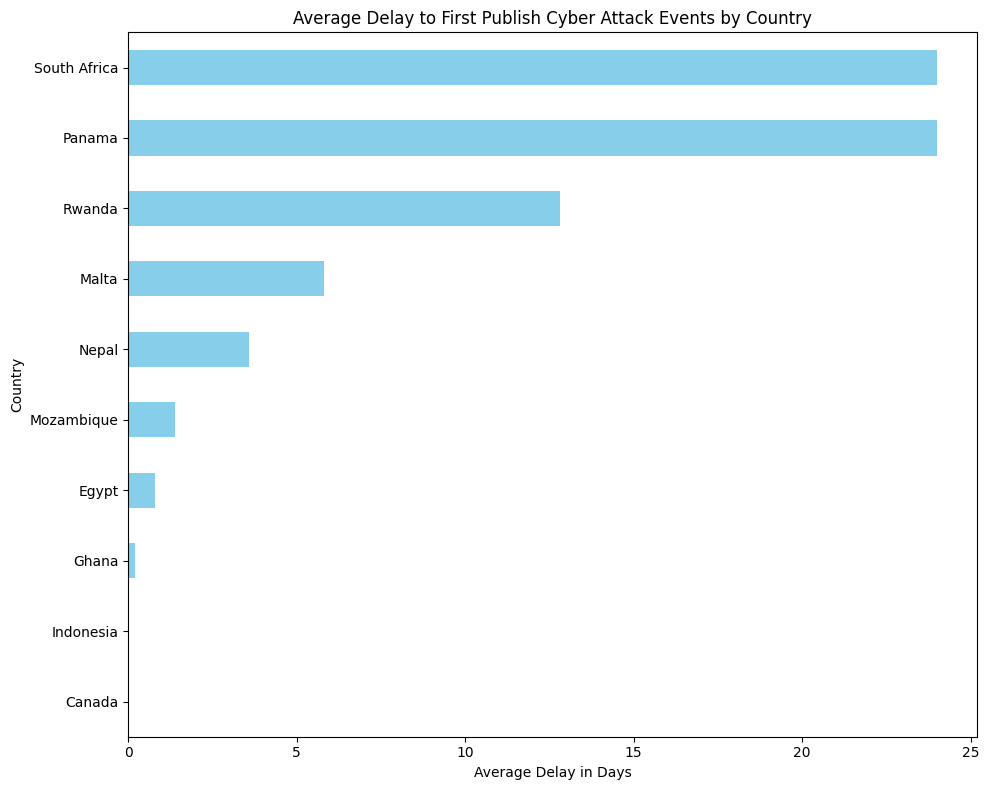

In [211]:
# Convert 'Timestamp_date' and 'first_publication_date' to datetime, handling errors
cyber_attacks_and_events_df['Timestamp_date'] = pd.to_datetime(cyber_attacks_and_events_df['Timestamp_date'])
cyber_attacks_and_events_df['first_publication_date'] = pd.to_datetime(cyber_attacks_and_events_df['first_publication_date'], errors='coerce')

# Assign 30 days for None values in 'first_publication_date'
default_delay = 30  # Use 30 days for cases with no publication date
# Calculate the delay in days, substituting default_delay for None values
cyber_attacks_and_events_df['publish_delay'] = (cyber_attacks_and_events_df['first_publication_date'] - cyber_attacks_and_events_df['Timestamp_date']).dt.days
cyber_attacks_and_events_df['publish_delay'].fillna(default_delay, inplace=True)

# Calculate the average delay per country
average_publish_delay = cyber_attacks_and_events_df.groupby('target_location_full_name')['publish_delay'].mean().sort_values()

# Plot the results with a horizontal bar chart
plt.figure(figsize=(10, 8))
average_publish_delay.plot(kind='barh', color='skyblue')
plt.xlabel('Average Delay in Days')
plt.ylabel('Country')
plt.title('Average Delay to First Publish Cyber Attack Events by Country')
plt.tight_layout()
plt.show()

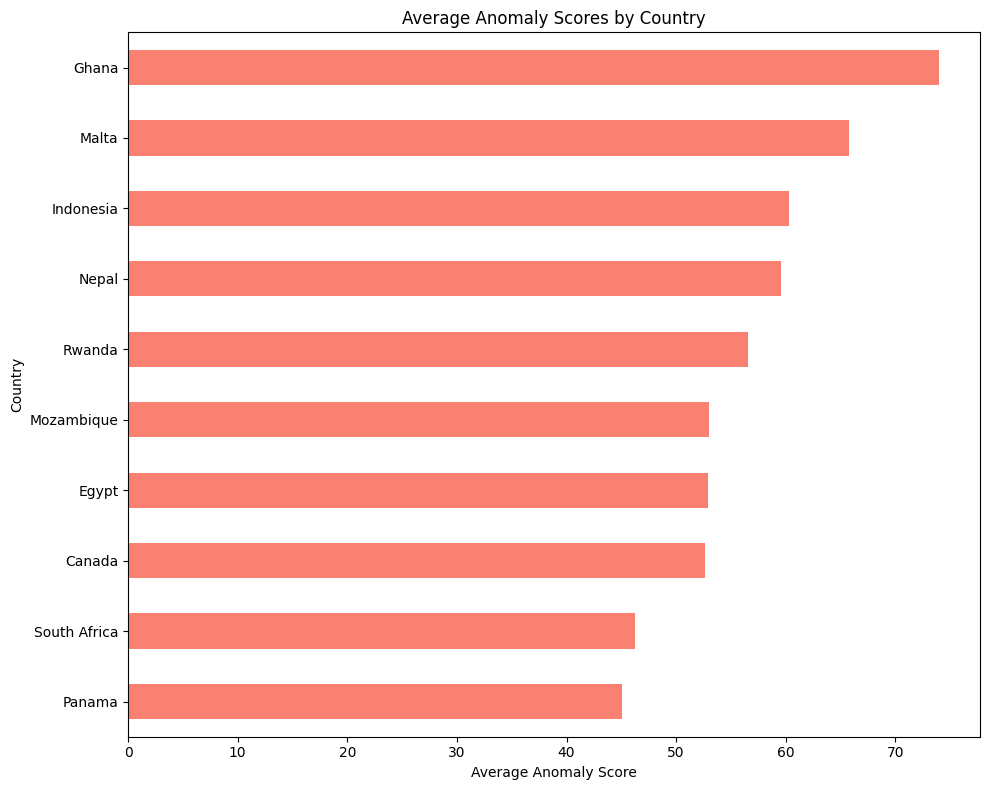

In [208]:
# Calculate the average Anomaly Score per country
average_anomaly_scores = cyber_attacks_and_events_df[cyber_attacks_and_events_df['target_location_full_name'].isin(cyber_attacks_and_events_df['target_location_full_name'])].groupby('target_location_full_name')['Anomaly Scores'].mean().sort_values()

# Plot the results with a horizontal bar chart
plt.figure(figsize=(10, 8))
average_anomaly_scores.plot(kind='barh', color='salmon')
plt.xlabel('Average Anomaly Score')
plt.ylabel('Country')
plt.title('Average Anomaly Scores by Country')
plt.tight_layout()
plt.show()

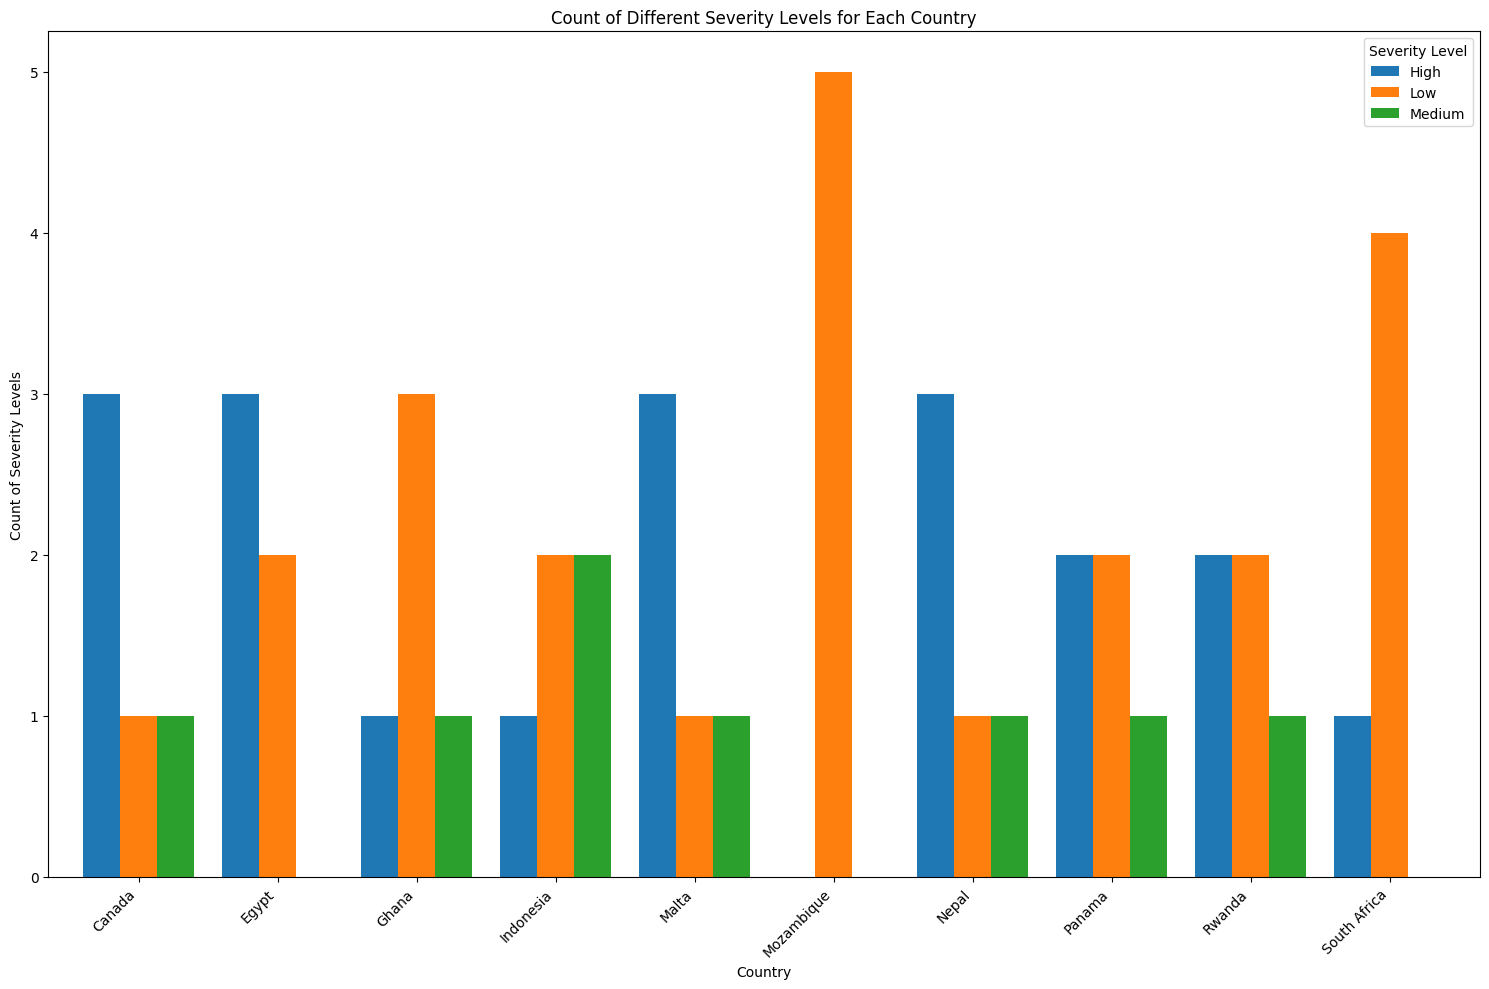

In [207]:
# Step 1: Count the number of different Severity Levels for each country
severity_counts = cyber_attacks_and_events_df.groupby(['target_location_full_name', 'Severity Level']).size().unstack(fill_value=0)

# Step 2: Plot the grouped bar chart
severity_counts.plot(kind='bar', figsize=(15, 10), width=0.8)
plt.xlabel('Country')
plt.ylabel('Count of Severity Levels')
plt.title('Count of Different Severity Levels for Each Country')
plt.xticks(rotation=45, ha="right")  # Rotate country names for better readability
plt.legend(title='Severity Level')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()